## ** Application of Artificial Intelligence (AI) to analyse and predict financial and non-financial risks**

**Loading packages**

In [6]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
pd.set_option('display.max_colwidth', -1)
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

#K-Means
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score

#NER
import re
import spacy
from spacy import displacy
from thefuzz import fuzz
from thefuzz import process

#Network analysis
import networkx as nx

#Metrics
import datetime as dt
import os
import math, time
import itertools
from operator import itemgetter
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#SQL
import sqlite3
import pandas as pd

#Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

#API connections
from yahoo_fin import stock_info
import yfinance as yf

#LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Arima
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

C:\Users\329707\AppData\Local\Temp\ipykernel_16504\2374206099.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# **Loading the data**

A connection was made to the outsourcing database and a SQL query was used to show all tables in the database. 

In [7]:
conn_new = sqlite3.connect("master.db")
curr = conn_new.cursor()
query = """SELECT name FROM sqlite_master WHERE type='table';"""
res = curr.execute(query)
print(res.fetchall())

[('aggregate_data',), ('AGGREGATE',), ('SERVICE_PROVIDERS',), ('FUZZY_ENTITIES',), ('COSTINGS',)]


# **Describing the data**

This project presents a proof of concept (PoC) for how named entity recognition (NER), network analysis, K-means clustering, LSTM and ARIMA models can be applied to analyse and predict financial and non-financial risks from unstructured information. Leveraging machine learning, data science and statistical methodologies through Python libraries such as SpaCy, Fuzzy, NetworkX, PyTorch and Pmdarima, it facilitates nuanced analysis to extract critical insights. Furthermore, the report sheds light on potential avenues for augmenting the precision of models and insights through sustained research and development.  

In [8]:
query = """SELECT * FROM AGGREGATE"""
df = pd.read_sql_query(query, conn_new)

**Description of variables**

Arrangement_ID: Unique outsourcing arrangement ID

R_firm: Name of firm

IBS: Important business service

Service_category: Category of service provided by supplier

Service_provider: Name of service provider used by firm

Entity_description: Description of service provider and their business

Financial_distress: 4-year average stress testing score of service provider

X1: first year stress testing score of service provider

X2: second year stress testing score of service provider

X3: third year stress testing score of service provider

X4: fourth year stress testing score of service provider

No_subcontractors: total number of subcontractors used by service provider

1st_subcontractor: name of first subcontractor used by service provider

2nd_subcontractor: name of second subcontractor used by 1st subcontractor

3rd_subcontractor: name of third subcontractor used by 2nd subcontractor

In [9]:
df.shape

(1228, 16)

There are 1228 rows and 6 columns in the dataset.

We can see that this dataset consists of three formats of data types:

object: these variables are categorical and consist of r_firm, IBS, service_category, service_provider, entity_description, no_subcontractors, 1st_subcontractor, 2nd_subcontractor, 3rd_subcontractor

int64: these are integer variables and consist of index and arrangement_ID

float64: these are numerical values that have decimals invoved and consist of Financial Distress. x1, x2, x3 and x4

# **Pre-Processing**

**Data Cleaning**

We will ensure our dataset is free from error by assessing null values. 

In [ ]:
df.isnull().sum()

We can see there is not a clean output and many missing values from the dataset, which would not be accepted by algorithms. We will use the following methods to fill in the missing values: imputation using median or mode for numerical variables and imputation using the mode for categorical variables. 

The median value will be used for imputation of the financial stress testing scores

In [12]:
df['Financial Distress'].fillna(df['Financial Distress'].median(), inplace=True)
df['x1'].fillna(df['x1'].median(), inplace=True)
df['x2'].fillna(df['x2'].median(), inplace=True)
df['x3'].fillna(df['x3'].median(), inplace=True)
df['x4'].fillna(df['x4'].median(), inplace=True)

In [ ]:
df.isnull().sum()

We can see that through the process of imputation there are now no missing values in the dataset.

In [14]:
df['no_subcontractors'].replace('3+', 3,inplace=True) 

The model algorithm only takes numerical variables therefore the variable +3 will need to be changed to 3 for the number of subcontractors as the model will not accept this value

**Named Entity Recognition**

A SQL query is defined as a string to select columns from the service providers table and data is retrived. 

In [15]:
query = """SELECT * FROM SERVICE_PROVIDERS"""
standardised_service_provider = pd.read_sql_query(query, conn_new)
standardised_service_provider_list = standardised_service_provider['Group_NameServiceProvider'].tolist()

The objective is to extract first sentences from each entity description and store them into a list.

In [16]:
first_sentences = []
desc = df['entity_description'].tolist()
desc = ['missing.' if x is np.nan else x for x in desc]
df['entity_description'] = desc
df.replace(np.nan,'Missing',regex=True) 

for sentence in desc:
    first_sentence = re.match(r'^.*?[.!?]', sentence)
    if first_sentence is None: 
        first_sentences.append("missing")
    else: 
        first_sentences.append(first_sentence.group(0))

SpaCys NER capabilities are often used for tasks such as extracting person names, locations, organisations, dates and more from text data making it valuable for information extraction and text analysis tasks. 
The SpaCy library is being used to perform NER on a given text string where the code contains SpaCys pre-trained NER model to recognise named entities. The text is passed to the SpaCy NER model for processing. 

In [18]:
NER = spacy.load("en_core_web_sm")
text = NER("FIRM 1 UK PLC")

def perform_ner(text):
    text = NER(text)
    entities = [ent.text for ent in text.ents]
    return entities

In [19]:
first_characters = []

for words in desc: 
    first_chars = words[0:40]
    first_characters.append(first_chars)

In [20]:
df['NER_Entities'] = df["entity_description"].apply(perform_ner)

max_entities = df['NER_Entities'].apply(lambda x: len(x)).max()
for i in range(max_entities):
    df[f"Entity{i+1}"] = df["NER_Entities"].apply(lambda x: x[i] if len(x) > i else None)

In [54]:
for sentence in first_sentences: 
    text = NER(sentence)
    print(sentence)
    for word in text.ents: 
        print(word.text,word.label_)

In [22]:
df.dropna(how='any',axis=0) 
df['Entity1'].isnull().sum()

0

In [23]:
df['Entity2'][2]

'Treasury Systems AG'

**Fuzzy Matching**

The fuzzy librarys string matching capabilities are used to compare with entities in the dataframe. The code applies different matching algorithms provided by the library to find the closest match and its corresponding score. 

In [25]:
df['fuzzymatch_tokenset'] = df['Entity1'].apply(
    lambda x: process.extractOne(x, standardised_service_provider_list, scorer = fuzz.token_set_ratio)[0] if x not in [None] else None)

df['score_entity1_tokenset'] = df['Entity1'].apply(
     lambda x: process.extractOne(x, standardised_service_provider_list, scorer = fuzz.token_set_ratio)[1] if x not in [None] else None)

df['fuzzymatch_tokensort'] = df['Entity1'].apply(
    lambda x: process.extractOne(x, standardised_service_provider_list, scorer = fuzz.token_sort_ratio)[0] if x not in [None] else None)

df['score_entity1_tokensort'] = df['Entity1'].apply(
    lambda x: process.extractOne(x, standardised_service_provider_list, scorer = fuzz.token_sort_ratio)[1] if x not in [None] else None)

df['fuzzymatch_ratio'] = df['Entity1'].apply(
    lambda x: process.extractOne(x, standardised_service_provider_list, scorer = fuzz.ratio)[0] if x not in [None] else None)

df['score_entity1_ratio'] = df['Entity1'].apply(
    lambda x: process.extractOne(x, standardised_service_provider_list, scorer = fuzz.ratio)[1] if x not in [None] else None)

df['fuzzymatch_partial_tokenset_ratio'] = df['Entity1'].apply(
    lambda x: process.extractOne(x, standardised_service_provider_list, scorer = fuzz.partial_token_sort_ratio)[0] if x not in [None] else None)

df['score_entity1_partial_tokenset_ratio'] = df['Entity1'].apply(
    lambda x: process.extractOne(x, standardised_service_provider_list, scorer = fuzz.partial_token_sort_ratio)[1] if x not in [None] else None)

A heatmap will be created to uncover the most accurate matches across all scores.

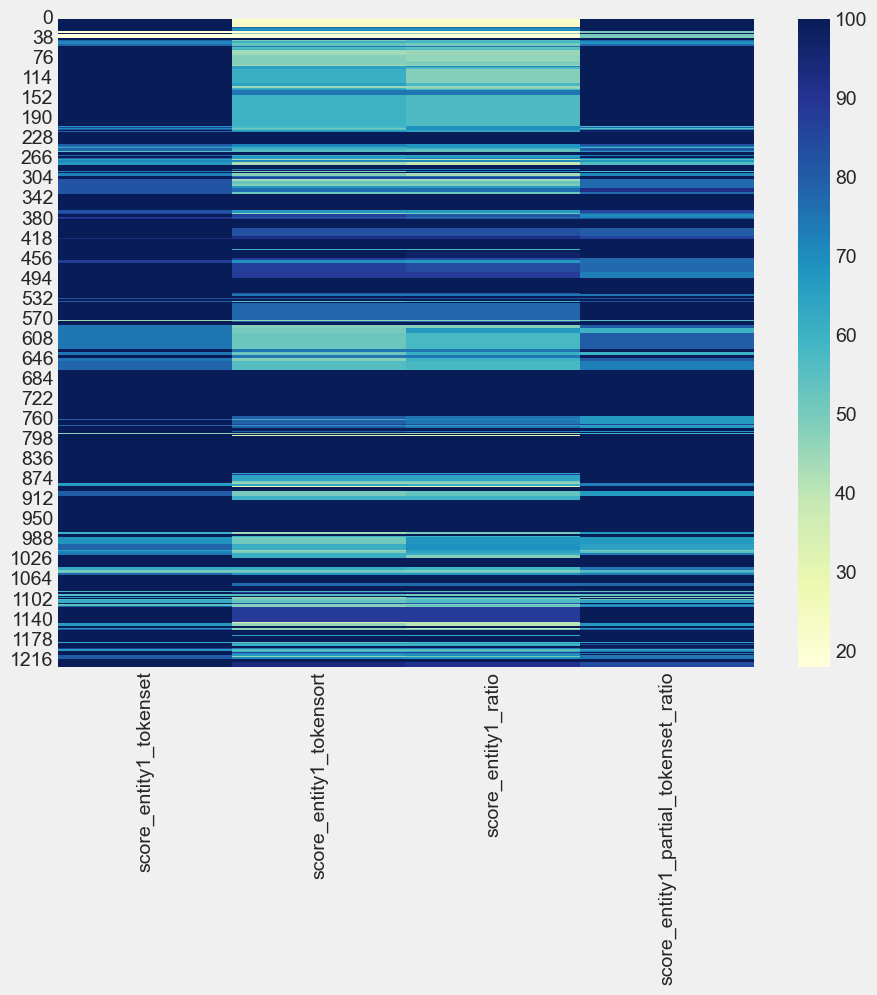

In [26]:
score_df = df[['score_entity1_tokenset', 'score_entity1_tokensort', 'score_entity1_ratio', 'score_entity1_partial_tokenset_ratio']]

plt.figure(figsize=(10, 8))
sns.heatmap(score_df, annot=False, cmap="YlGnBu")
plt.show()

A distribution will be created to uncover the most accurate matches across all scores.

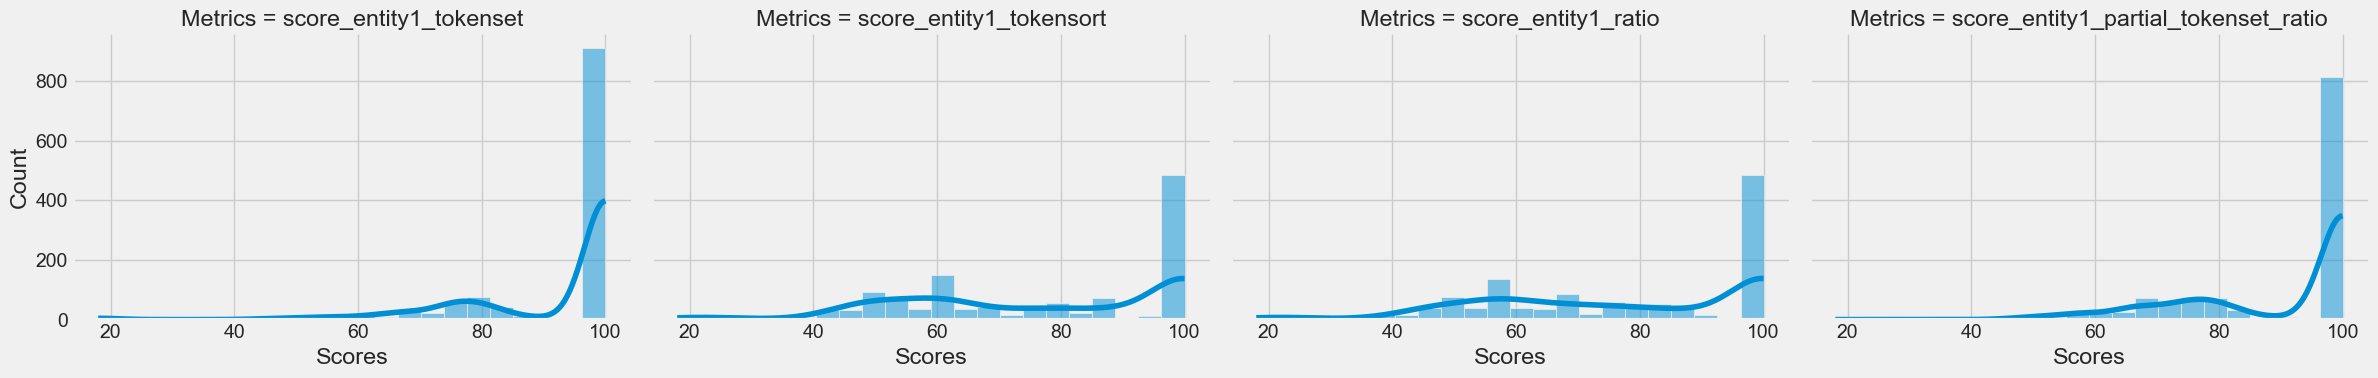

In [27]:
score_df = df[['score_entity1_tokenset', 'score_entity1_tokensort', 'score_entity1_ratio', 'score_entity1_partial_tokenset_ratio']]

score_dist = score_df.melt(var_name='Metrics', value_name='Scores')

g = sns.displot(data=score_dist, x='Scores', col='Metrics', kde=True, height=4, aspect=1.5)
plt.show()

# **Exploratory Analysis**

We will explore elements of our datasets through visual analysis.

In [31]:
total_IBS = df.IBS.value_counts().to_frame()
total_IBS

,IBS
Payments,425
Corporate Finance,209
Sales and Trading,176
Asset Management,118
Commercial Banking,109
Retail Banking,68
Retail Brokerage,62
Agency Services,61


In [32]:
total_IBS.sort_values("IBS", ascending=False, inplace=True)

total_IBS["type"] = ""
for i in range(0, len(total_IBS)):
    if any(x in total_IBS.index[i] for x in df):
        total_IBS["type"][i] = "#037761"
    else:
        total_IBS["type"][i] = "#85B09A"
total_IBS.reset_index(inplace=True, drop=False)

C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3700420373.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_IBS["type"][i] = "#85B09A"


We will create a bar chart to reveal the IBS categories.

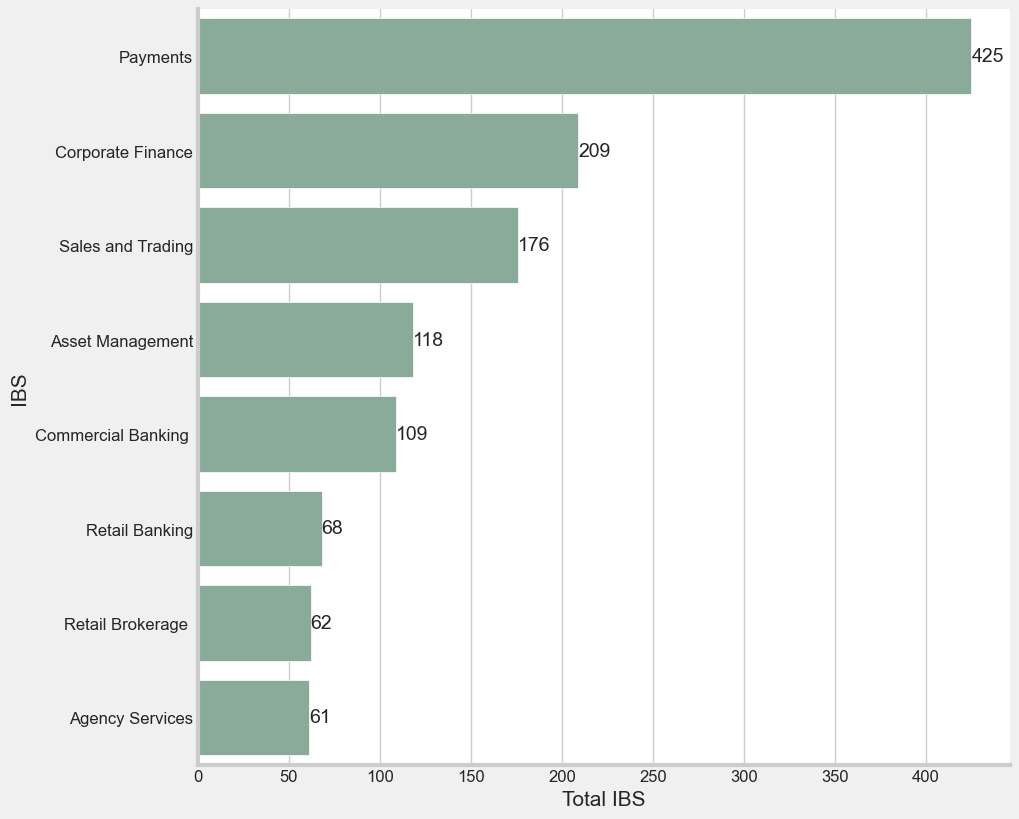

In [33]:
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=total_IBS.iloc[0:20, :], x="IBS", y="index", palette=total_IBS["type"]
)
plt.xlabel("Total IBS", fontsize=15)
plt.ylabel("IBS", fontsize=15)
plt.tick_params(labelsize=12)
ax.bar_label(ax.containers[0])
sns.despine()
plt.tight_layout(pad=0)
plt.show()

We can see that across all firms, Payments is the most popular IBS category with 425 arrangements supporting that segment.  

In [34]:
total_service_category = df.service_category.value_counts().to_frame()
total_service_category.sort_values("service_category", ascending=False, inplace=True)
total_service_category["service"] = ""
for i in range(0, len(total_service_category)):
    if any(x in total_service_category.index[i] for x in df):
        total_service_category["service"][i] = "#037761"
    else:
        total_service_category["service"][i] = "#85B09A"
total_service_category.reset_index(inplace=True, drop=False)

C:\Users\329707\AppData\Local\Temp\ipykernel_16504\2605225207.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_service_category["service"][i] = "#85B09A"


We will create a bar chart to reveal the service categories.

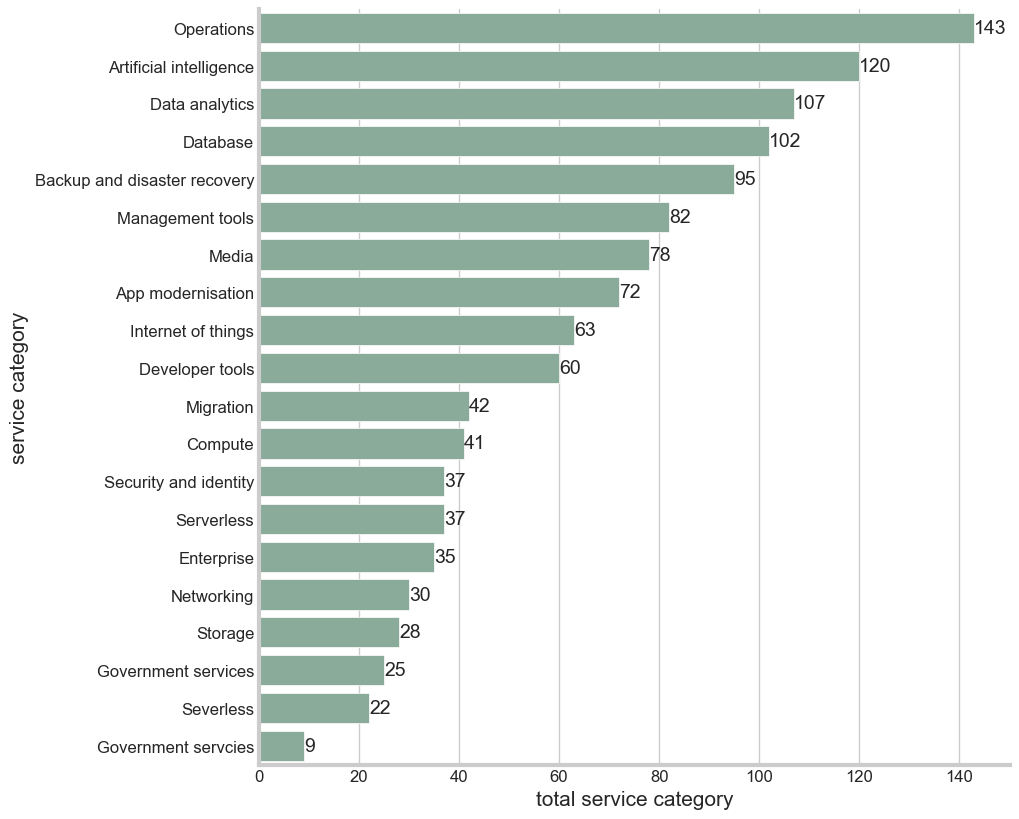

In [25]:
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=total_service_category.iloc[0:20, :], x="service_category", y="index", palette=total_service_category["service"]
)
plt.xlabel("total service category", fontsize=15)
plt.ylabel("service category", fontsize=15)
plt.tick_params(labelsize=12)
ax.bar_label(ax.containers[0])
sns.despine()
plt.tight_layout(pad=0)
plt.show()

We can see that across all firms, Operations is the most popular service category.

# **K-means clustering**

K-means clustering is an example of unsupervised learning. The model can facilitate with understanding behavioural patterns that impact costings across IBS's. It is a helpful technique for the organisation to identify IBS's in terms of their risk profile, where it groups based on similar features. We will use K-means to segment IBS's into different groups based on low-risk, medium-risk and high-risk. These three clusters can be assigned as initial centroids, which will help reveal which points in the dataset are closest to each cluster.

A SQL query is defined as a string to select columns from the costings table and data is retrived.

In [37]:
query = """SELECT * FROM COSTINGS"""
costings = pd.read_sql_query(query, conn_new)

In [38]:
costings=costings.dropna()

In [39]:
X = costings[['upcoming_estimated_budget', 'annual_expense', 'previous_expense']]
y = costings['IBS']

In [40]:
model = KMeans(n_clusters=3)

In [41]:
model.fit(X)

KMeans(n_clusters=3)

We will test the clusters that exist across upcoming estimated budget and annual expense. First we will assign points to the closest cluster centroid, then recompute centroids of newly formed clusters then repeat both steps. 

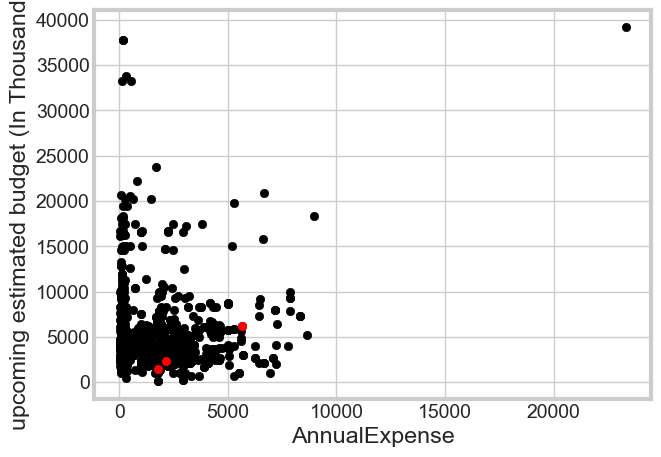

In [43]:
Z = costings[["upcoming_estimated_budget","annual_expense"]]
K=3
Centroids = (Z.sample(n=K))
plt.scatter(X["annual_expense"],Z["upcoming_estimated_budget"],c='black')
plt.scatter(Centroids["annual_expense"],Centroids["upcoming_estimated_budget"],c='red')
plt.xlabel('AnnualExpense')
plt.ylabel('upcoming estimated budget (In Thousands)')
plt.show()

In [44]:
diff = 1
j=0

while(diff!=0):
    XD=Z
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["annual_expense"]-row_d["annual_expense"])**2
            d2=(row_c["upcoming_estimated_budget"]-row_d["upcoming_estimated_budget"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        Z[i]=ED
        i=i+1

    C=[]
    for index,row in Z.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    Z["Cluster"]=C
    Centroids_new = Z.groupby(["Cluster"]).mean()[["upcoming_estimated_budget","annual_expense"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['upcoming_estimated_budget'] - Centroids['upcoming_estimated_budget']).sum() + (Centroids_new['annual_expense'] - Centroids['annual_expense']).sum()
        print(diff.sum())
    Centroids = Z.groupby(["Cluster"]).mean()[["upcoming_estimated_budget","annual_expense"]]

C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

2402.4751361832323


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


1895.5398352563718


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


1785.8478988102602


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


2546.7504406111752


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


2483.8209602728202


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


1330.347973857501


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


467.13609168619587


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


449.0264810390736


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


30.6602534476433


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


17.923865876179207


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


65.14454609108657


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C
C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z[i]=ED


19.00944334590531
0.0


C:\Users\329707\AppData\Local\Temp\ipykernel_16504\3033080139.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z["Cluster"]=C


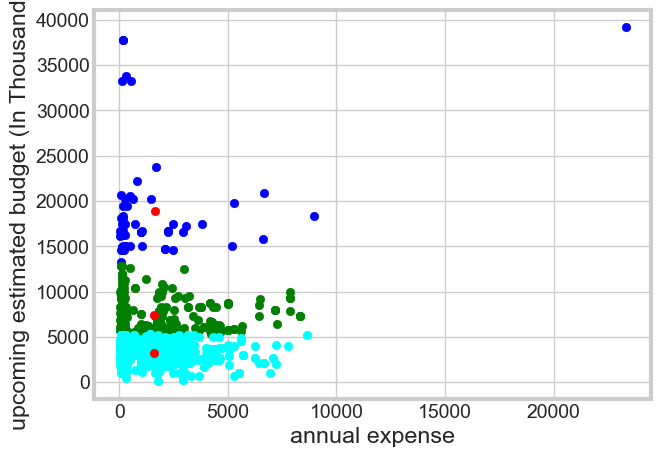

<Figure size 640x480 with 0 Axes>

In [45]:
color=['blue','green','cyan']
for k in range(K):
    data=Z[Z["Cluster"]==k+1]
    plt.scatter(data["annual_expense"],data["upcoming_estimated_budget"],c=color[k])
plt.scatter(Centroids["annual_expense"],Centroids["upcoming_estimated_budget"],c='red')
plt.xlabel('annual expense')
plt.ylabel('upcoming estimated budget (In Thousands)')
plt.show()

plt.savefig('2D_KMEANS.png', bbox_inches='tight')

The diagram shows clusters highlighted around three centroids highlighted in red. The clusters may depict the different risk groups such as low-risk, medium-risk and high-risk. The colours blue, green and cyan help identify IBS's of different risk groups. This helps us understand that various risk levels exist across IBS's based on their costings, meaning that if a service provider supporting a high-risk arrangement was to be disrupted, it could pose a systemic risk to financial stability.

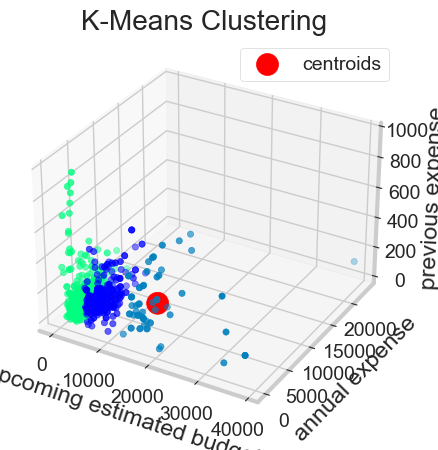

In [48]:
km = KMeans(3)
clusts = km.fit_predict(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            km.cluster_centers_[:, 2],
            s = 250,
            marker='o',
            c='red',
            label='centroids')
scatter = ax.scatter(costings['upcoming_estimated_budget'],costings['annual_expense'], costings['previous_expense'],
                     c=clusts,s=20, cmap='winter')


ax.set_title('K-Means Clustering')
ax.set_xlabel('upcoming estimated budget')
ax.set_ylabel('annual expense')
ax.set_zlabel('previous expense')
ax.legend()
plt.show()

From the 3D graph we can see three clusters have formed. The green and dark blue clusters are stronger, therefore there is more evidence to support that there are more IBS's that identify as low-risk and medium-risk based on their financial costings (upcoming estimated budget, annual expense and previous expense) and only a few IBS's identified as high-risk. 

**Evaluating K-means**

Silhouette analysis will be used to evaluate the K-Means clustering model. The silhouette scores will enable us to assess whether k values are significant, which will also identify whether outliers exist in the dataset and ensure clusters are assigned to the correct centroids. 

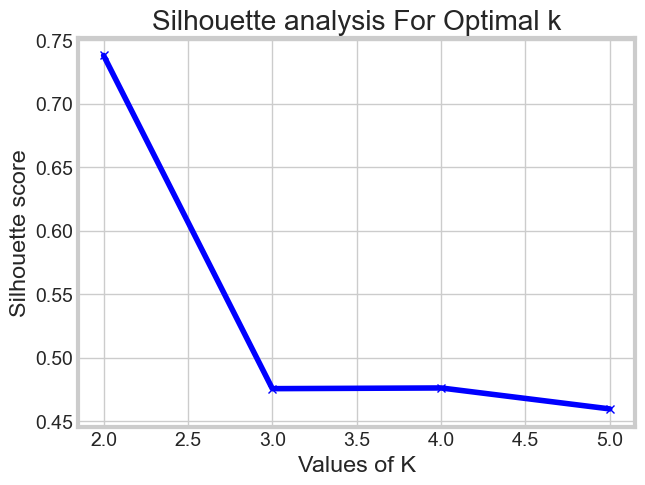

In [49]:
range_n_clusters = [2, 3, 4, 5]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X)
  cluster_labels = kmeans.labels_

  silhouette_avg.append(silhouette_score(X, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

From the silhouette analysis, we can see that a K value of 2 produces the highest silhouette score which suggests the optimal number of clusters would be two. Anything greater than this value causes the silhouette score to diminish as we increase the K value.

# **Assessing Non-Financial Risks**

**Network Analysis**

A SQL query is defined as a string to select columns from the fuzzy entites table and data is retrived.

In [50]:
query = """SELECT * FROM FUZZY_ENTITIES"""
fuzzy_ents = pd.read_sql_query(query, conn_new)

In [56]:
fuzzy_ents["fuzzymatch_tokenset"] = fuzzy_ents["fuzzymatch_tokenset"].apply(eval)

In [57]:
fuzzy_ents = fuzzy_ents.rename(columns={'fuzzymatch_tokenset': 'group_service_provider'})

In [58]:
fuzzy_ents["first_subcontractor"] = fuzzy_ents["first_subcontractor"].apply(eval)
fuzzy_ents["second_subcontractor"] = fuzzy_ents["second_subcontractor"].apply(eval)
fuzzy_ents["third_subcontractor"] = fuzzy_ents["third_subcontractor"].apply(eval)

A network analysis diagram will be created to represent the relationship between firms, service providers, and subcontractors at various levels in the supply chain across three layers. The nodes positioning is determined using the spring layout and their sizes are scaled based on the sum of their adjacent nodes degrees. 

In [ ]:
plt.rcParams['figure.figsize'] = [30, 25]

start = time.time()

P = nx.Graph()

for index, row in fuzzy_ents.iterrows():
    P.add_nodes_from([row["r_firm"]])
    P.add_edges_from( [(row["r_firm"], node) for node in row["group_service_provider"]])
    
    for group_service_provider in row['group_service_provider']:
        for first_subcontractor in row['first_subcontractor']:
            P.add_edge(group_service_provider, first_subcontractor)
            for second_subcontractor in row['second_subcontractor']:
                P.add_edge(first_subcontractor, second_subcontractor)
                for third_subcontractor in row['third_subcontractor']:
                    P.add_edge(second_subcontractor, third_subcontractor)

pos = nx.spring_layout(P)

node_degrees = dict(P.degree)
total_degrees = [sum(node_degrees[node] for node in neighbors) for node, neighbors in P.adjacency()]

node_size = [degree * 10 for degree in total_degrees]

edges = nx.draw_networkx_edges(P, pos=pos, alpha = 0.1, edge_color = 'black')

node_colors = [] #store colors for nodes
for node in P.nodes():
    if node in fuzzy_ents['r_firm'].values:
        node_colors.append('pink')
    elif node in fuzzy_ents['group_service_provider'].explode().values:
            node_colors.append('blue')
    elif node in fuzzy_ents['first_subcontractor'].explode().values:
        node_colors.append('green')
    elif node in fuzzy_ents['second_subcontractor'].explode().values:
        node_colors.append('orange')
    elif node in fuzzy_ents['third_subcontractor'].explode().values:
        node_colors.append('yellow')
    else: 
        node_colors.append('gray')

nx.draw_networkx_nodes(P, pos=pos, node_size=node_size, alpha=0.4, node_color=node_colors)

labels = {row["r_firm"]:row["r_firm"] for index, row in fuzzy_ents.iterrows()}
group_labels = {node: node for node in P.nodes() if node not in labels}
labels.update(group_labels)

draw_labels = nx.draw_networkx_labels(P, pos=pos, labels = labels, font_size = 10)

plt.savefig('supply_chain_1.png', bbox_inches='tight')

end = time.time()
print("Execution time: " + str(end-start))

The second network analysis diagram visualises a network graph representing relationships between firms, service providers and multiple tiers of subcontractors. The graphs layout is determined by the Fruchterman-Reingold algorithm. Nodes represent entities (firms, service providers and subcontractors) based on their degree with the most connected node highlighted in red. Edges depict the relationships between these entities. 

In [ ]:
plt.rcParams['figure.figsize'] = [30, 25]

start = time.time()

P = nx.Graph()

for index, row in fuzzy_ents.iterrows():
    P.add_nodes_from([row["r_firm"]])
    P.add_edges_from( [(row["r_firm"], node) for node in row["group_service_provider"]])
    
    for group_service_provider in row['group_service_provider']:
        for first_subcontractor in row['first_subcontractor']:
            P.add_edge(group_service_provider, first_subcontractor)
            for second_subcontractor in row['second_subcontractor']:
                P.add_edge(first_subcontractor, second_subcontractor)
                for third_subcontractor in row['third_subcontractor']:
                    P.add_edge(second_subcontractor, third_subcontractor)

pos = nx.fruchterman_reingold_layout(P, seed=7, k=0.5)

d = dict(P.degree)
node_size = [v * 20 for v in d.values()]

edges = nx.draw_networkx_edges(P, pos, edgelist=P.edges(), alpha = 0.1, edge_color = 'black')

node_degrees = dict(P.degree)
top_node = max(node_degrees, key=node_degrees.get)

node_colors = ['red' if node == top_node else color for node, color in zip(P.nodes(), node_colors)]

nodes = nx.draw_networkx_nodes(P, pos, node_size = 2500, alpha = 0.4, node_color=node_colors)

labels = {row["r_firm"]:row["r_firm"] for index, row in fuzzy_ents.iterrows()}
group_labels = {node: node for node in P.nodes() if node not in labels}
labels.update(group_labels)

nx.draw_networkx_labels(P, pos, labels=labels, font_size = 12, font_family = "sans-serif")

plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

plt.savefig('supply_chain_2.png', bbox_inches='tight')

end = time.time()
print("Execution time: " + str(end-start))

**Centrality Measures**

Centrality measures (degree, betweenness, closeness and eigenvector centrality) are important metrics for understanding network structures and node importance. 

In [66]:
#Degree centrality
d = nx.degree_centrality(P)

deg_centrality = tuple( sorted(d.items(),
                           key=lambda item: item[1],
                           reverse=True))

top_deg_centrality = deg_centrality[0]
top_deg_centrality

('GOOGLE LLC', 0.8)

The degree centrality tells us which node ranks importance according to connectivity.

In [67]:
#Closeness centrality
d = nx.closeness_centrality(P)

clos_centrality = tuple( sorted(d.items(),
                           key=lambda item: item[1],
                           reverse=True))

top_clos_centrality = clos_centrality[0]
top_clos_centrality

('GOOGLE LLC', 0.8333333333333334)

The closeness centrality tells us how close one vertex is with another vertex in the network. 

In [68]:
#Eigenvector centrality
d= nx.eigenvector_centrality_numpy(P)

eig_centrality = tuple( sorted(d.items(),
                           key=lambda item: item[1],
                           reverse=True))

top_eig_centrality = eig_centrality[0]
top_eig_centrality

('GOOGLE LLC', 0.2255463909302985)

The eigenvector centrality tells us about the significance of a vertex according to the relative importance of the vertices connected to it. 

In [69]:
#Betweeness centrality
d = nx.betweenness_centrality(P)

betw_centrality = tuple( sorted(d.items(),
                           key=lambda item: item[1],
                           reverse=True))

top_betw_centrality = betw_centrality[0]
top_betw_centrality

('AMAZON', 0.08089995467119034)

The betweeness centrality tells us about the role of the vertex as a connector through which information can flow across the network.

# **Predicting Financial Risks**

In [46]:
stock_info.get_live_price("GOOG")

138.4600067138672

Google stock market data has been exported from Yahoo Finance which covers the period 2013 - 2023. Features of this dataset include the Open, High, Low and Close prices of Google's stock, and also covers the Volume of trades. 

In [47]:
goog = yf.download(tickers='GOOG',period='10y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [48]:
goog.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-20,22.375879,22.518845,22.306889,22.493439,22.493439,174463490
2013-09-23,22.320089,22.455582,22.047361,22.079741,22.079741,71362485
2013-09-24,22.079741,22.169403,21.952717,22.088207,22.088207,59694916
2013-09-25,22.080984,22.080984,21.808256,21.848854,21.848854,66207234
2013-09-26,21.875505,21.986340,21.793312,21.872267,21.872267,50584897


In [49]:
goog.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-14,138.389999,139.550003,137.059998,138.990005,138.990005,19064600
2023-09-15,138.800003,139.360001,137.179993,138.300003,138.300003,48947600
2023-09-18,137.630005,139.929993,137.630005,138.960007,138.960007,16233600
2023-09-19,138.250000,139.175003,137.500000,138.830002,138.830002,15479100
2023-09-20,138.250000,138.839996,138.220001,138.460007,138.460007,1488297


We will ensure our dataset is free from error by removing null values.

In [50]:
print ("\nMissing values :  ", goog.isnull().sum().values.sum())
print ("\nUnique values :  \n", goog.nunique())


Missing values :   0

Unique values :  
 Open         2453
High         2479
Low          2483
Close        2485
Adj Close    2485
Volume       2433
dtype: int64


In [51]:
goog.dropna(inplace=True)
goog.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [52]:
goog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-09-20 to 2023-09-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


We will conduct visual analysis to assess the trends across all variables overtime. 

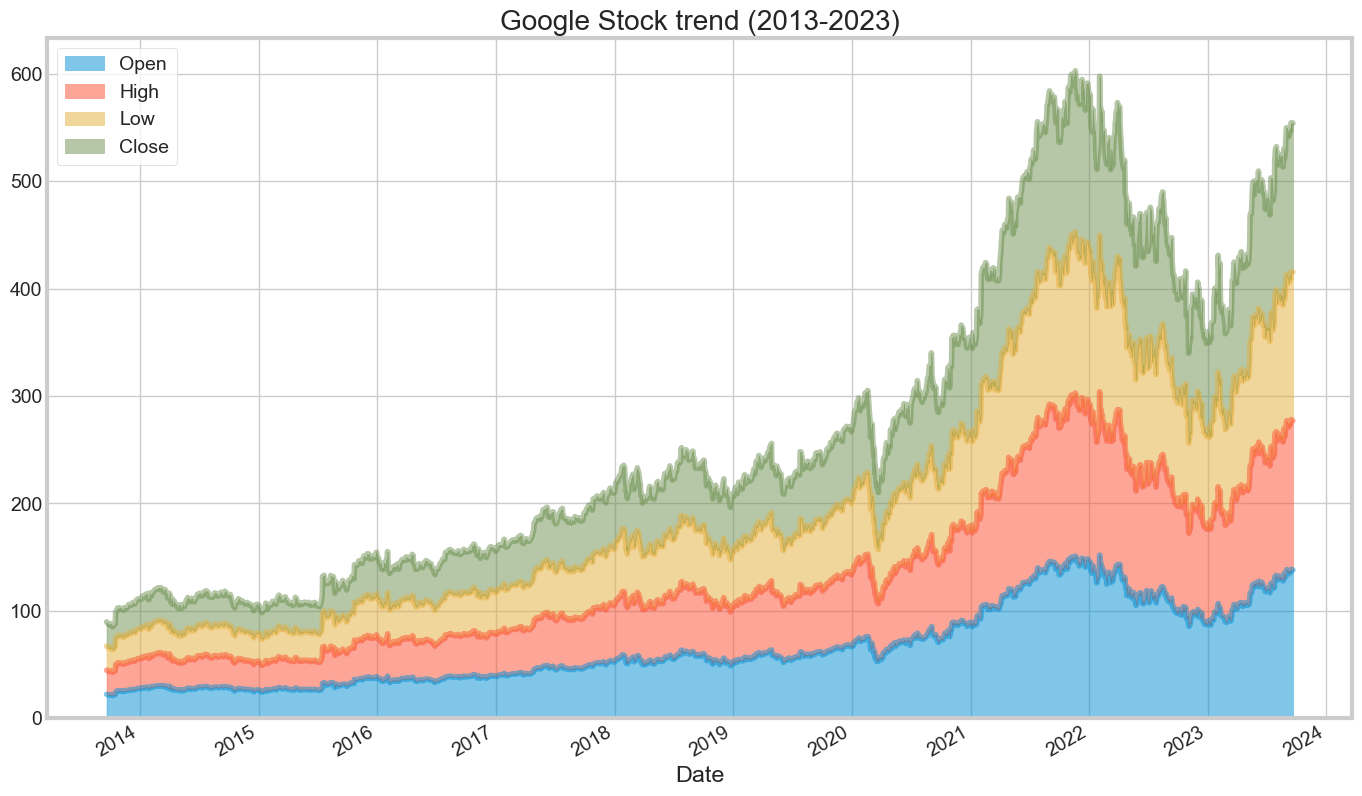

In [53]:
goog[["Open","High","Low","Close"]].plot.area(figsize=(15,10),alpha=0.5);
plt.title('Google Stock trend (2013-2023)')
plt.show()

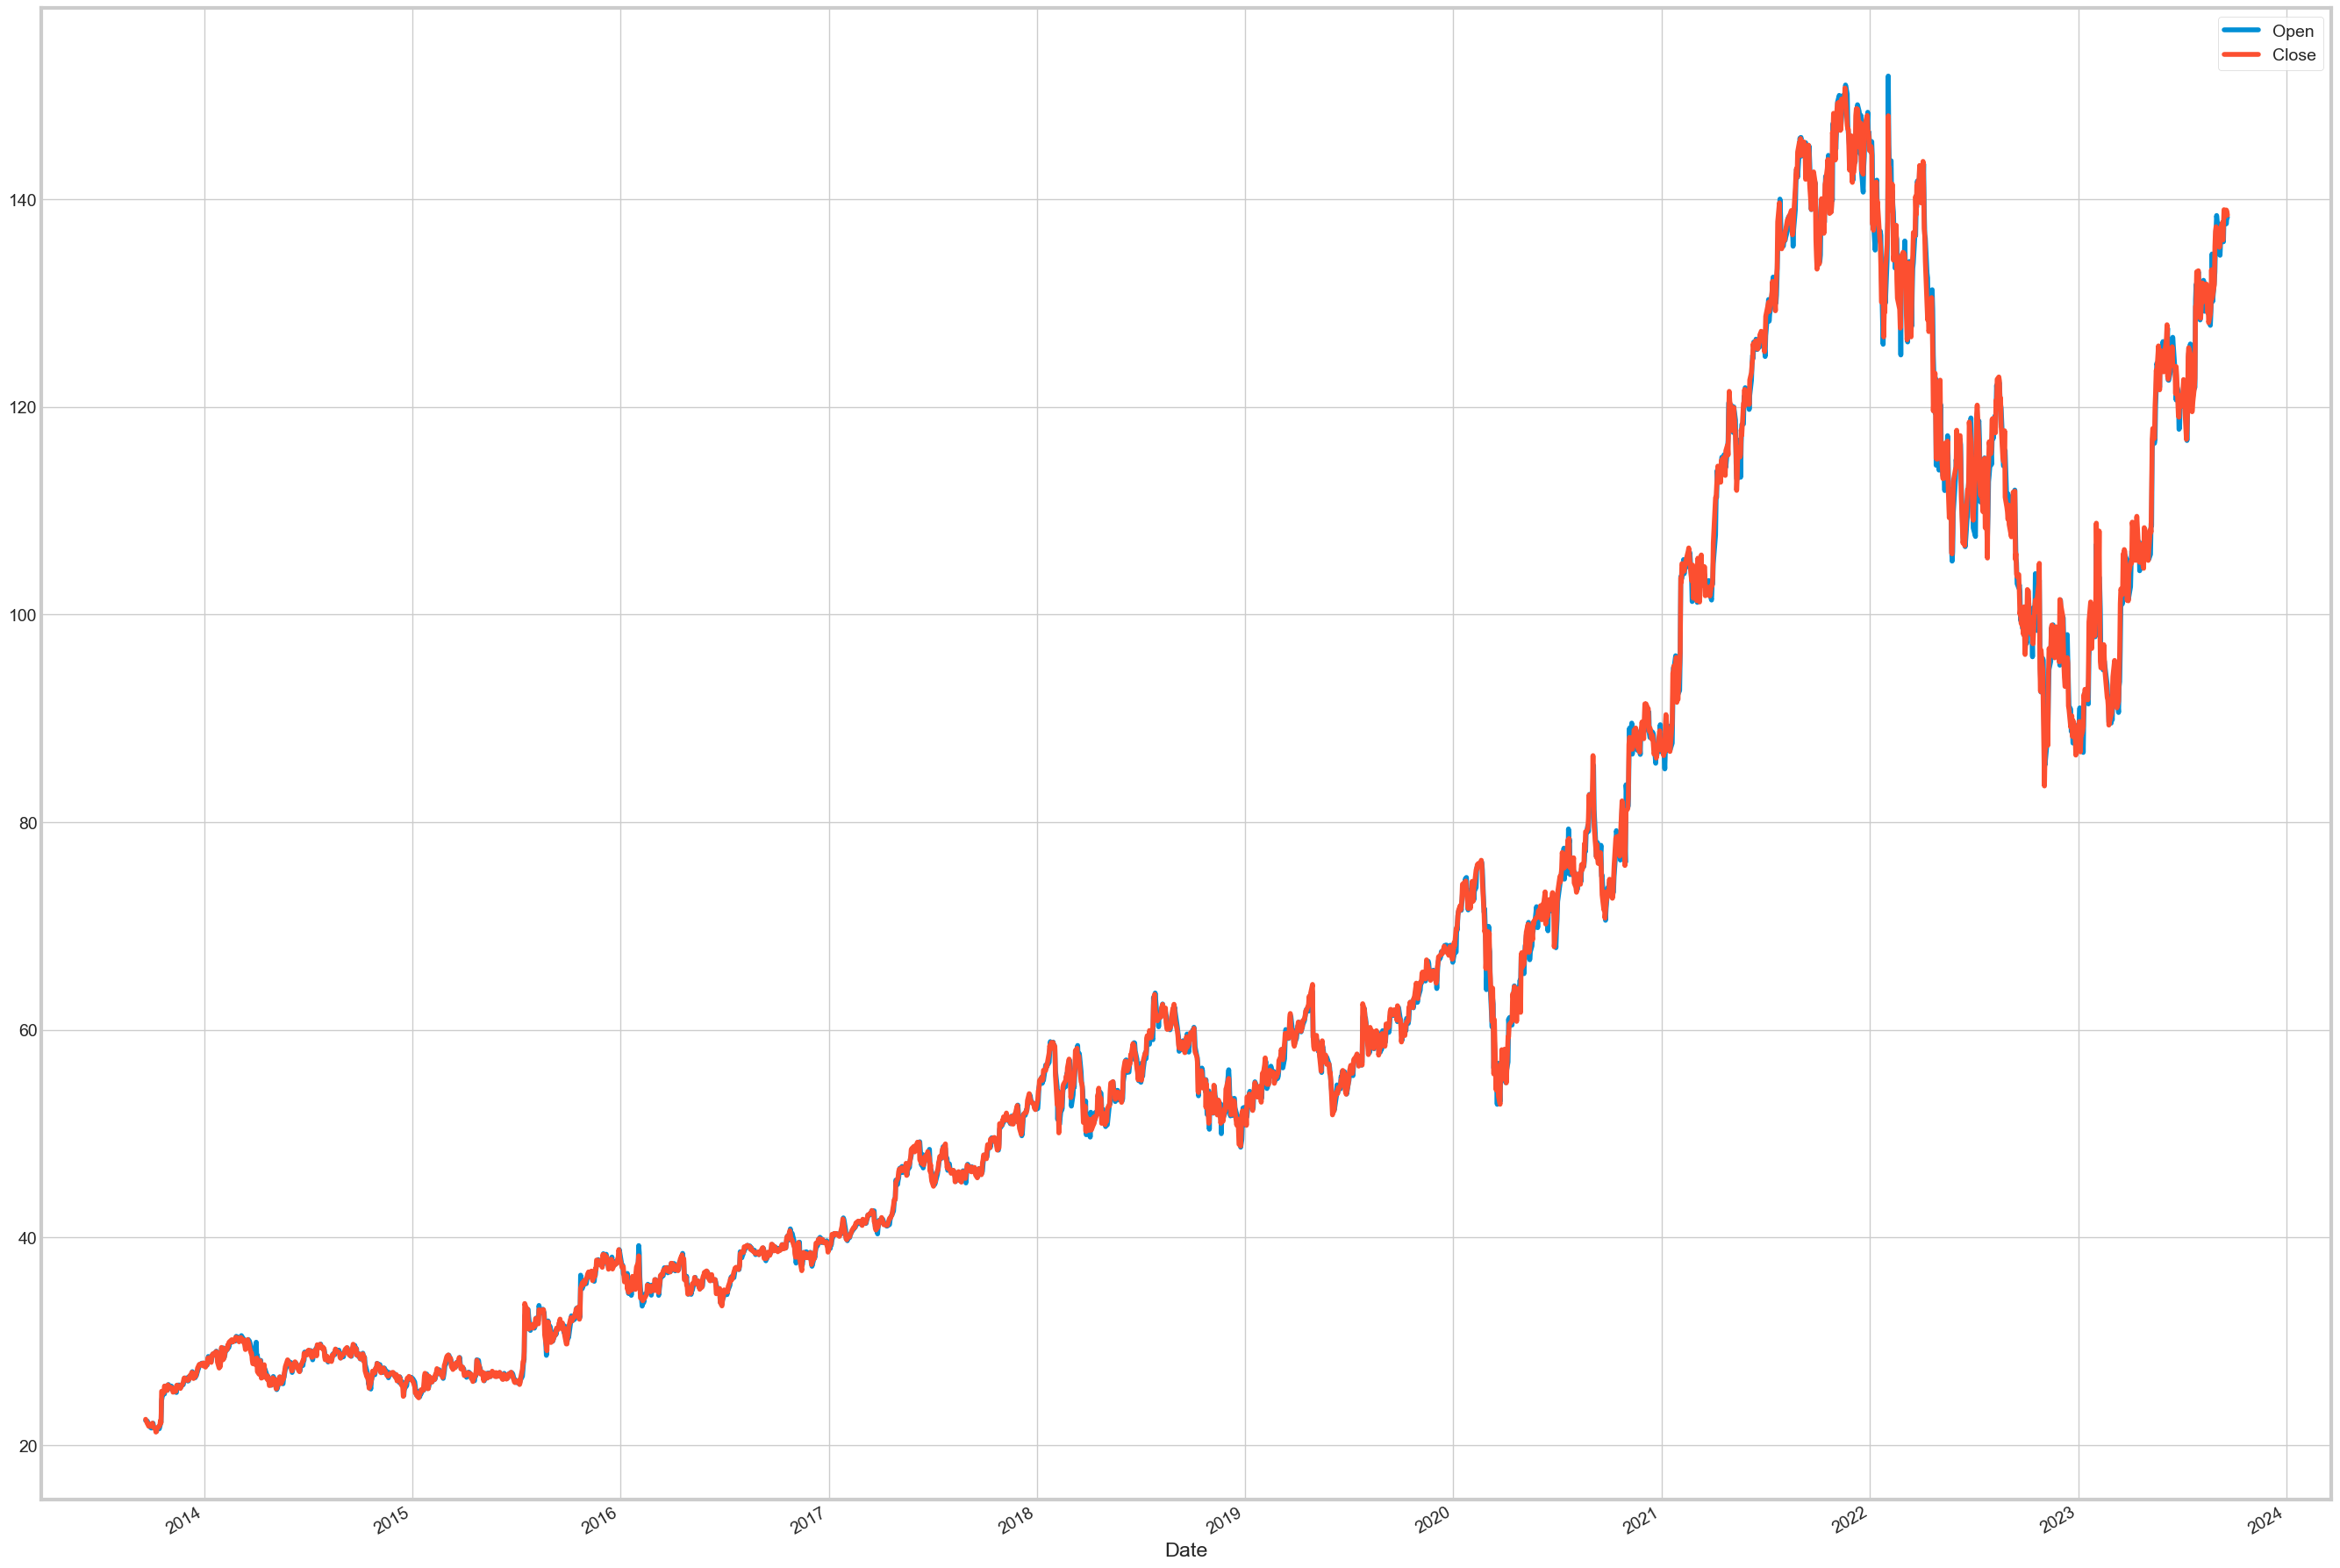

In [54]:
goog[['Open','Close']].plot()
plt.show()

We can see from the plot above that open and close prices follow similar trends and there are no major discrepencies.

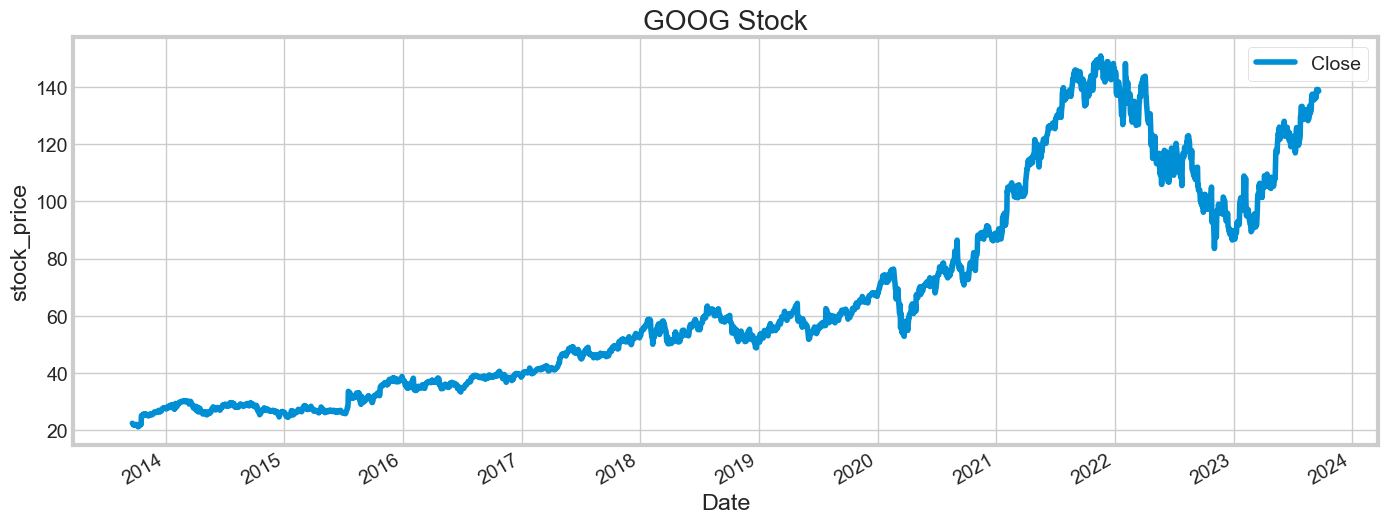

In [55]:
close_goog = goog[['Close']]
close_goog.plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("GOOG Stock")
plt.show()

The plot above shows Google's closing price overtime, this value represents the closing price of shares at the end of that day.

**Long short-term memory (LSTM)**

We will use LSTM to predict the stock price of Google. LSTM is an RNN technique that is able to learn from lon-term dependecies and accurately predict stock prices from time-series data. The dataset will be normalised via the MinMaxScalar to scale deate within the [0,1] or [-1,1] range, as we expect to see negative price ranges in our dataset. PyTorch will be used to build the model as it is compatible with GPU acceleration and other Python libraries. 

In [56]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
close_goog['Close'] = sc.fit_transform(close_goog['Close'].values.reshape(-1,1))

C:\Users\329707\AppData\Local\Temp\ipykernel_13308\2573886706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_goog['Close'] = sc.fit_transform(close_goog['Close'].values.reshape(-1,1))


The data has been split into 80% training set and 20% testing set. The lookback period has been defined over 20 sequences meaning it will use the past 20 data points to predict the next one.

In [57]:
def load_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    X_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    X_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [X_train, y_train, X_test, y_test]
lookback = 20 
X_train, y_train, X_test, y_test = load_data(close_goog, lookback)

In [59]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

Hyperparameters will be defined, including epochs, hidden size, input size, output size, hidden state and number of layers. 

In [61]:
input_dim = 1 #input gate (adds information to the cell state)
hidden_dim = 32 #hidden state
num_layers = 2 #number of layers
output_dim = 1 #output size (selects information to be shown as output)

The forward pass and backpropagation will now be applied.

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

The LSTM model will be defined, as well as the loss function and optimiser.

In [63]:
lstm_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)
print(len(list(lstm_model.parameters())))
for i in range(len(list(lstm_model.parameters()))):
    print(list(lstm_model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


The model will be trained, which involves looping for the number of epochs, completing the forward pass, obtaining the loss function, adjusting weights through the optimiser. We will train for 100 epochs and print the loss function at intervals of 10 epochs. 

In [64]:
num_epochs = 100
hist = np.zeros(num_epochs)

seq_dim =lookback-1  

for t in range(num_epochs):
    y_train_pred = lstm_model(X_train)

    loss_function = loss(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss_function.item())
    hist[t] = loss_function.item()
    optimiser.zero_grad()
    loss_function.backward()
    optimiser.step()

Epoch  10 MSE:  0.027157606557011604
Epoch  20 MSE:  0.002677618758752942
Epoch  30 MSE:  0.00252542900852859
Epoch  40 MSE:  0.00070370570756495
Epoch  50 MSE:  0.00030271217110566795
Epoch  60 MSE:  0.0001990440214285627
Epoch  70 MSE:  0.00016331799270119518
Epoch  80 MSE:  0.00012645816605072469
Epoch  90 MSE:  0.00012293919280637056


Results indicate there is a reduction of loss at every 10 epochs.

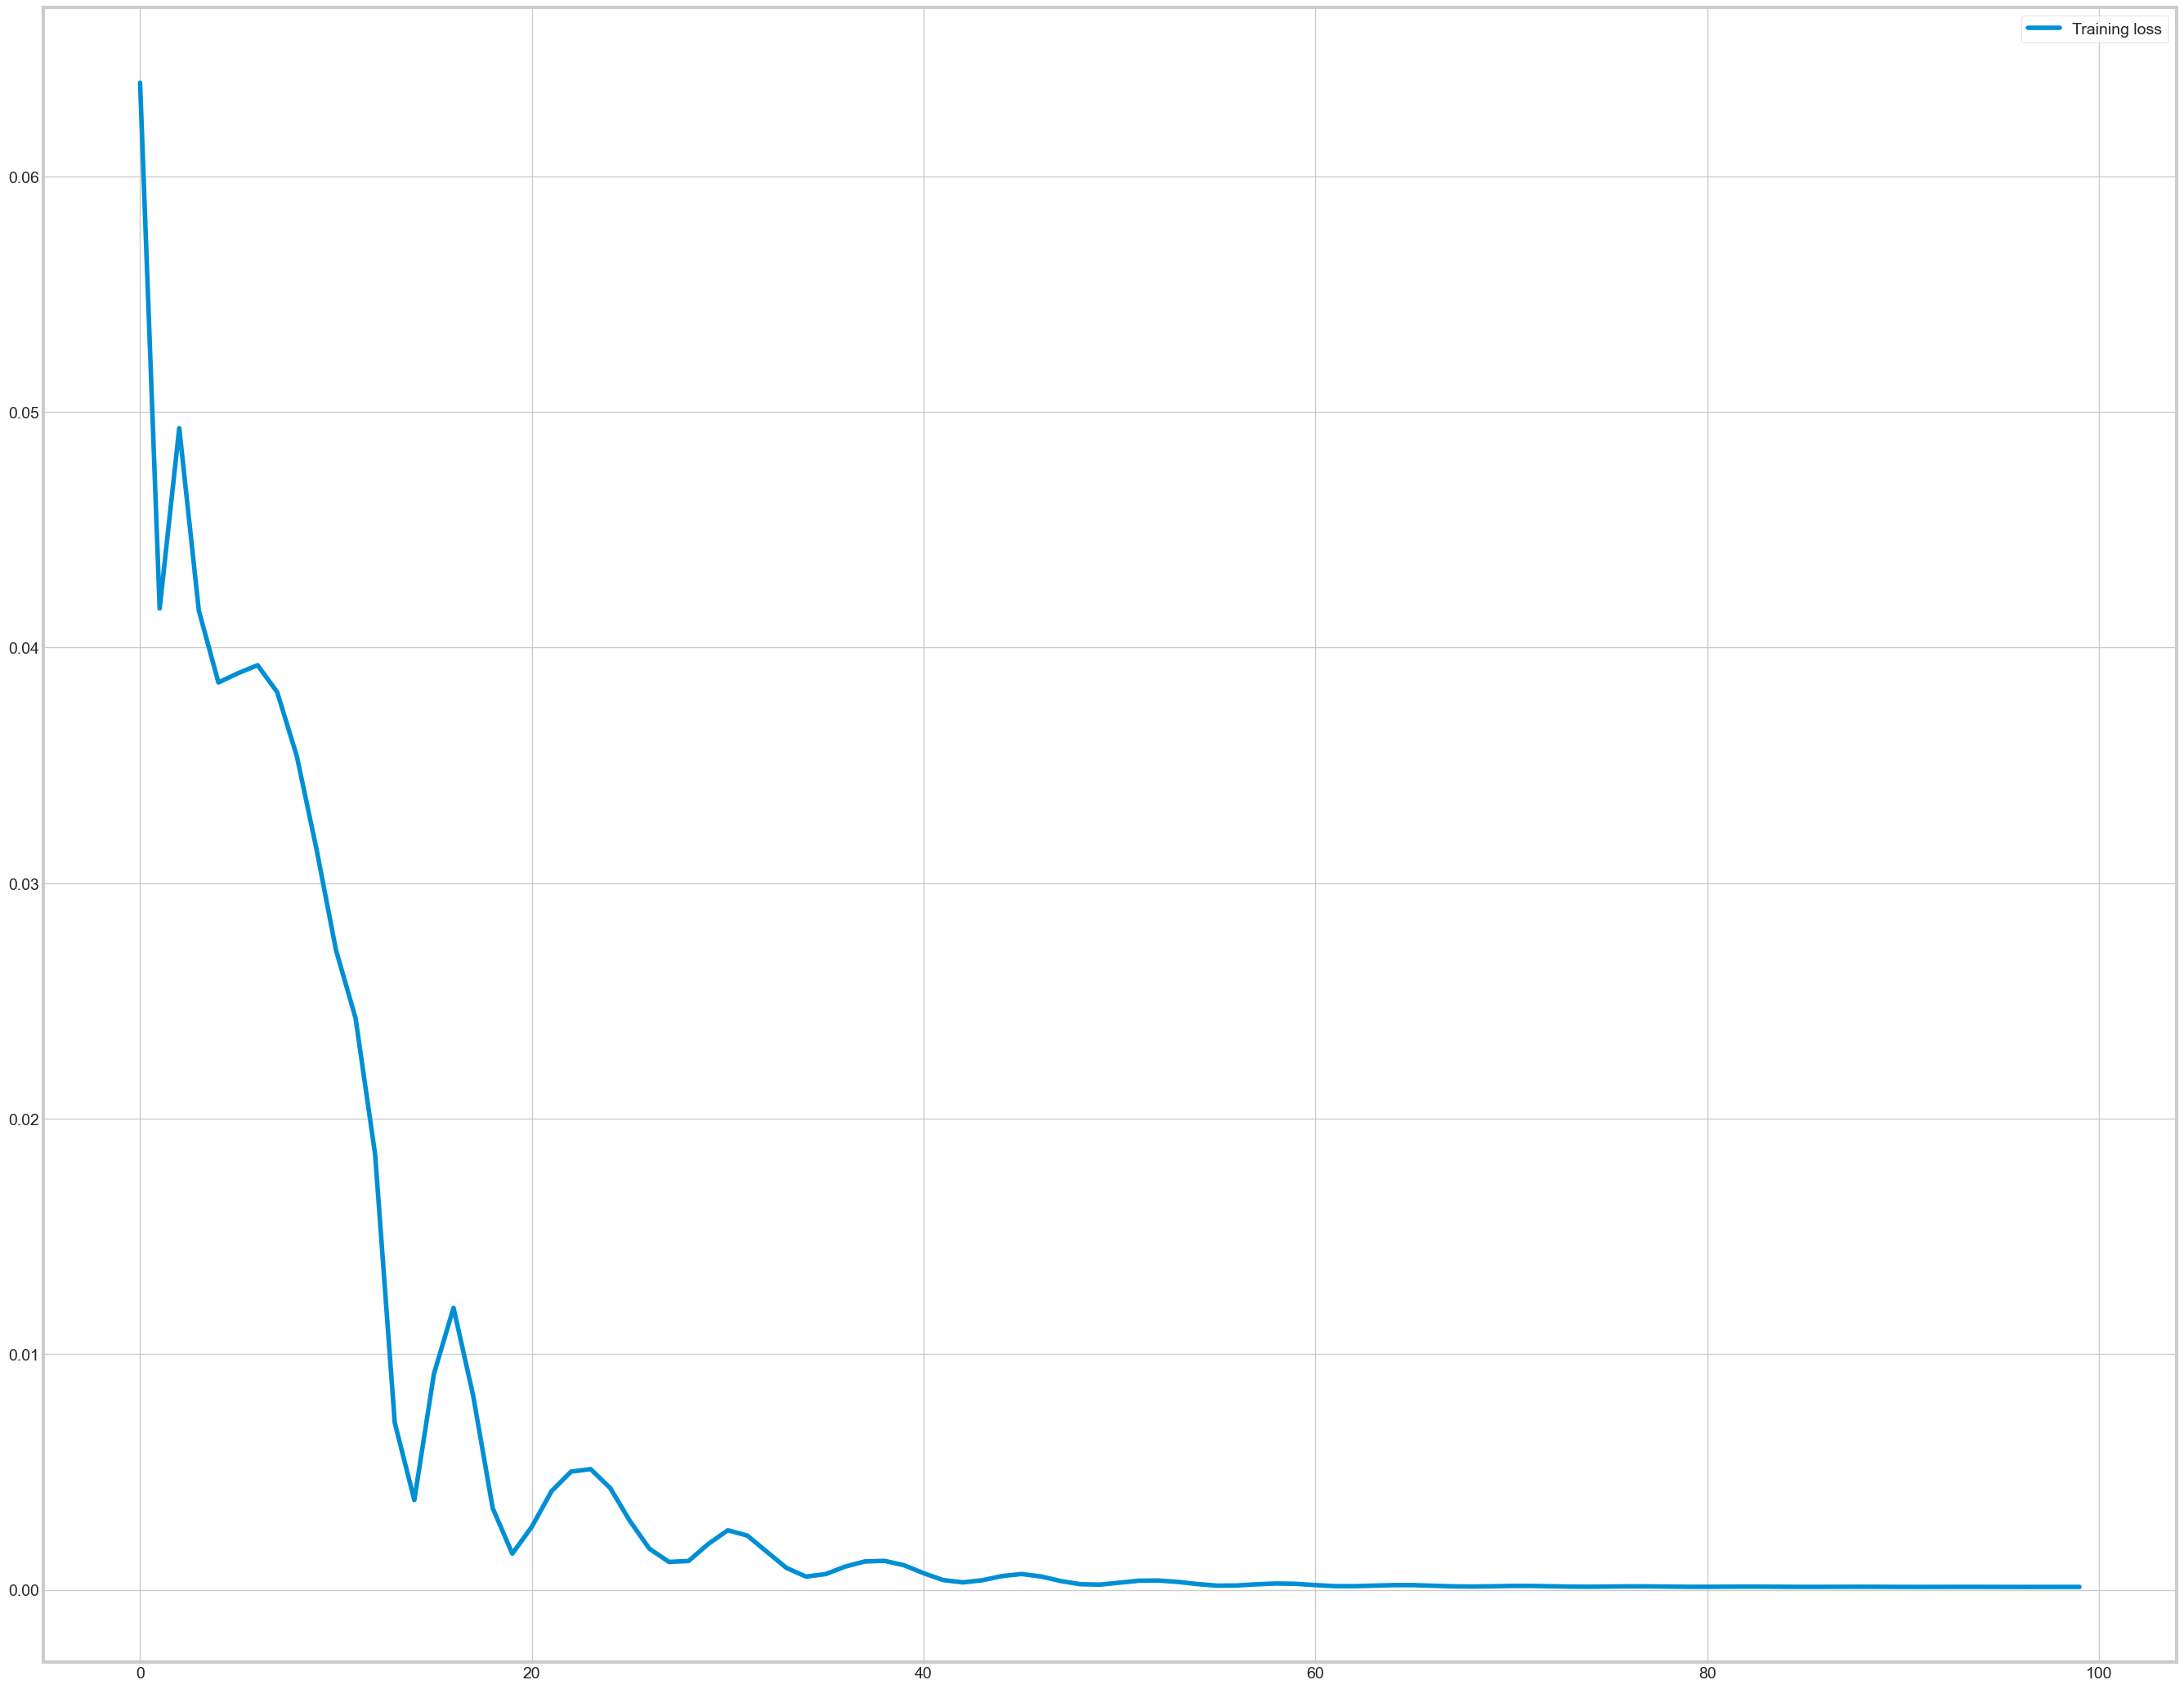

In [65]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

The diagram above shows the decreasing training loss as the number of epochs increase, indicating that the LSTM model is learning and improving its performance on the training dataset. 

Predictions and transformation will now be performed on the whole dataset.

In [66]:
y_test_pred = lstm_model(X_test)

y_train_pred = sc.inverse_transform(y_train_pred.detach().numpy())
y_train = sc.inverse_transform(y_train.detach().numpy())
y_test_pred = sc.inverse_transform(y_test_pred.detach().numpy())
y_test = sc.inverse_transform(y_test.detach().numpy())

We will use evaluation metrics: Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) to measure the error of the LSTM model.


In [67]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.43 RMSE
Test Score: 3.97 RMSE


In [68]:
# calculate mean squared error
trainScore1 = mean_squared_error(y_train[:,0], y_train_pred[:,0])
testScore1 = mean_squared_error(y_test[:,0], y_test_pred[:,0])
print('Train Score: %.2f MSE' % (trainScore1))
print('Test Score: %.2f MSE' % (testScore1))

Train Score: 2.05 MSE
Test Score: 15.73 MSE


In [69]:
# calculate mean squared error
trainScore2 = mean_absolute_error(y_train[:,0], y_train_pred[:,0])
testScore2 = mean_absolute_error(y_test[:,0], y_test_pred[:,0])
print('Train Score: %.2f MAE' % (trainScore2))
print('Test Score: %.2f MAE' % (testScore2))

Train Score: 0.97 MAE
Test Score: 3.16 MAE


Despite the detailed architecture, the model displayed errors in prediction, indicated by metrics such as Root Mean Squared Error (RMSE) [3.97], Mean Squared Error (MSE) [15.73], and Mean Absolute Error (MAE) [3.16]. The error measures indicated that either biases could exist in the training data, which undermined predictions made by the model or that the hyperparameters required further fine-tuning. 

We will now visualise the test prediction and assess how well the model is performing. 

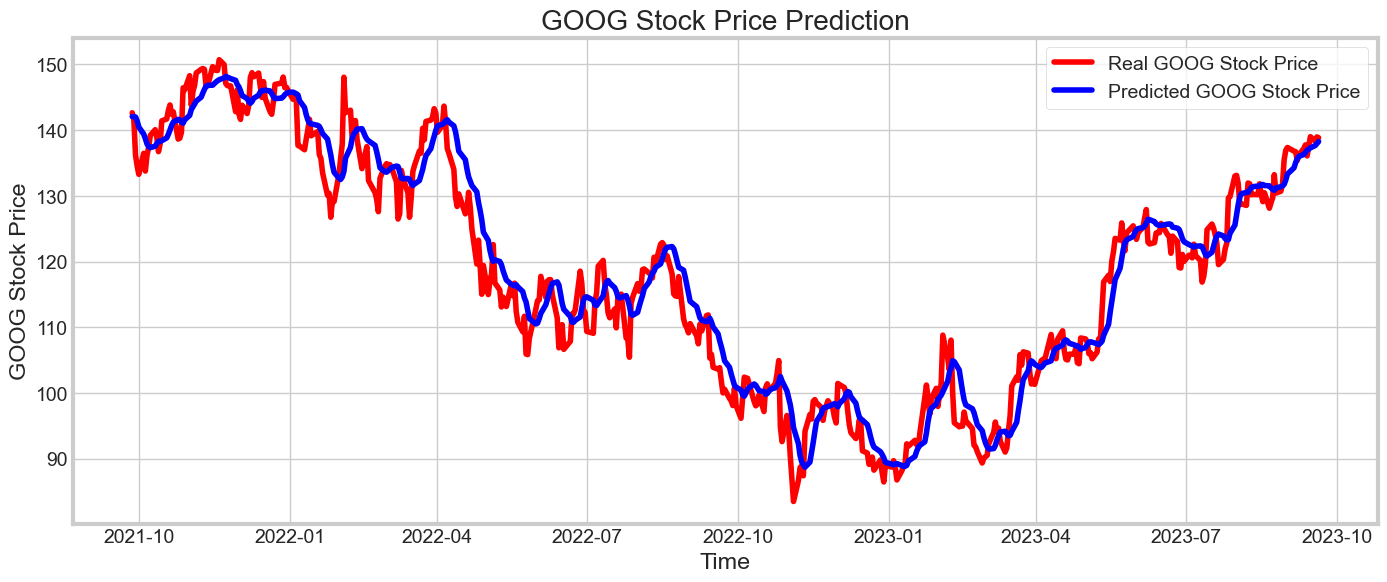

<Figure size 3000x2500 with 0 Axes>

In [70]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(close_goog[len(close_goog)-len(y_test):].index, y_test, color = 'red', label = 'Real GOOG Stock Price')
axes.plot(close_goog[len(close_goog)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted GOOG Stock Price')

plt.title('GOOG Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOG Stock Price')
plt.legend()
plt.savefig('goog_pred.png')
plt.show()

plt.savefig('LSTM_prediction.png', bbox_inches='tight')

The LSTM model has produced some promising results, displaying similar movements to the real GOOG stock price, however in some cases it underperformed or outperformed in certain periods compared to the actual stock price.

**Autoregressive integrated moving average (ARIMA)**

In [71]:
df_goog = goog[['Close']]

In [72]:
df_goog

,Close
Date,
2013-09-20,22.493439
2013-09-23,22.079741
2013-09-24,22.088207
2013-09-25,21.848854
2013-09-26,21.872267
...,...
2023-09-14,138.990005
2023-09-15,138.300003
2023-09-18,138.960007


We will conduct a stationary yesy by looking at Partial Autocorrelation and Autocorrelation plots.

C:\Miniconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


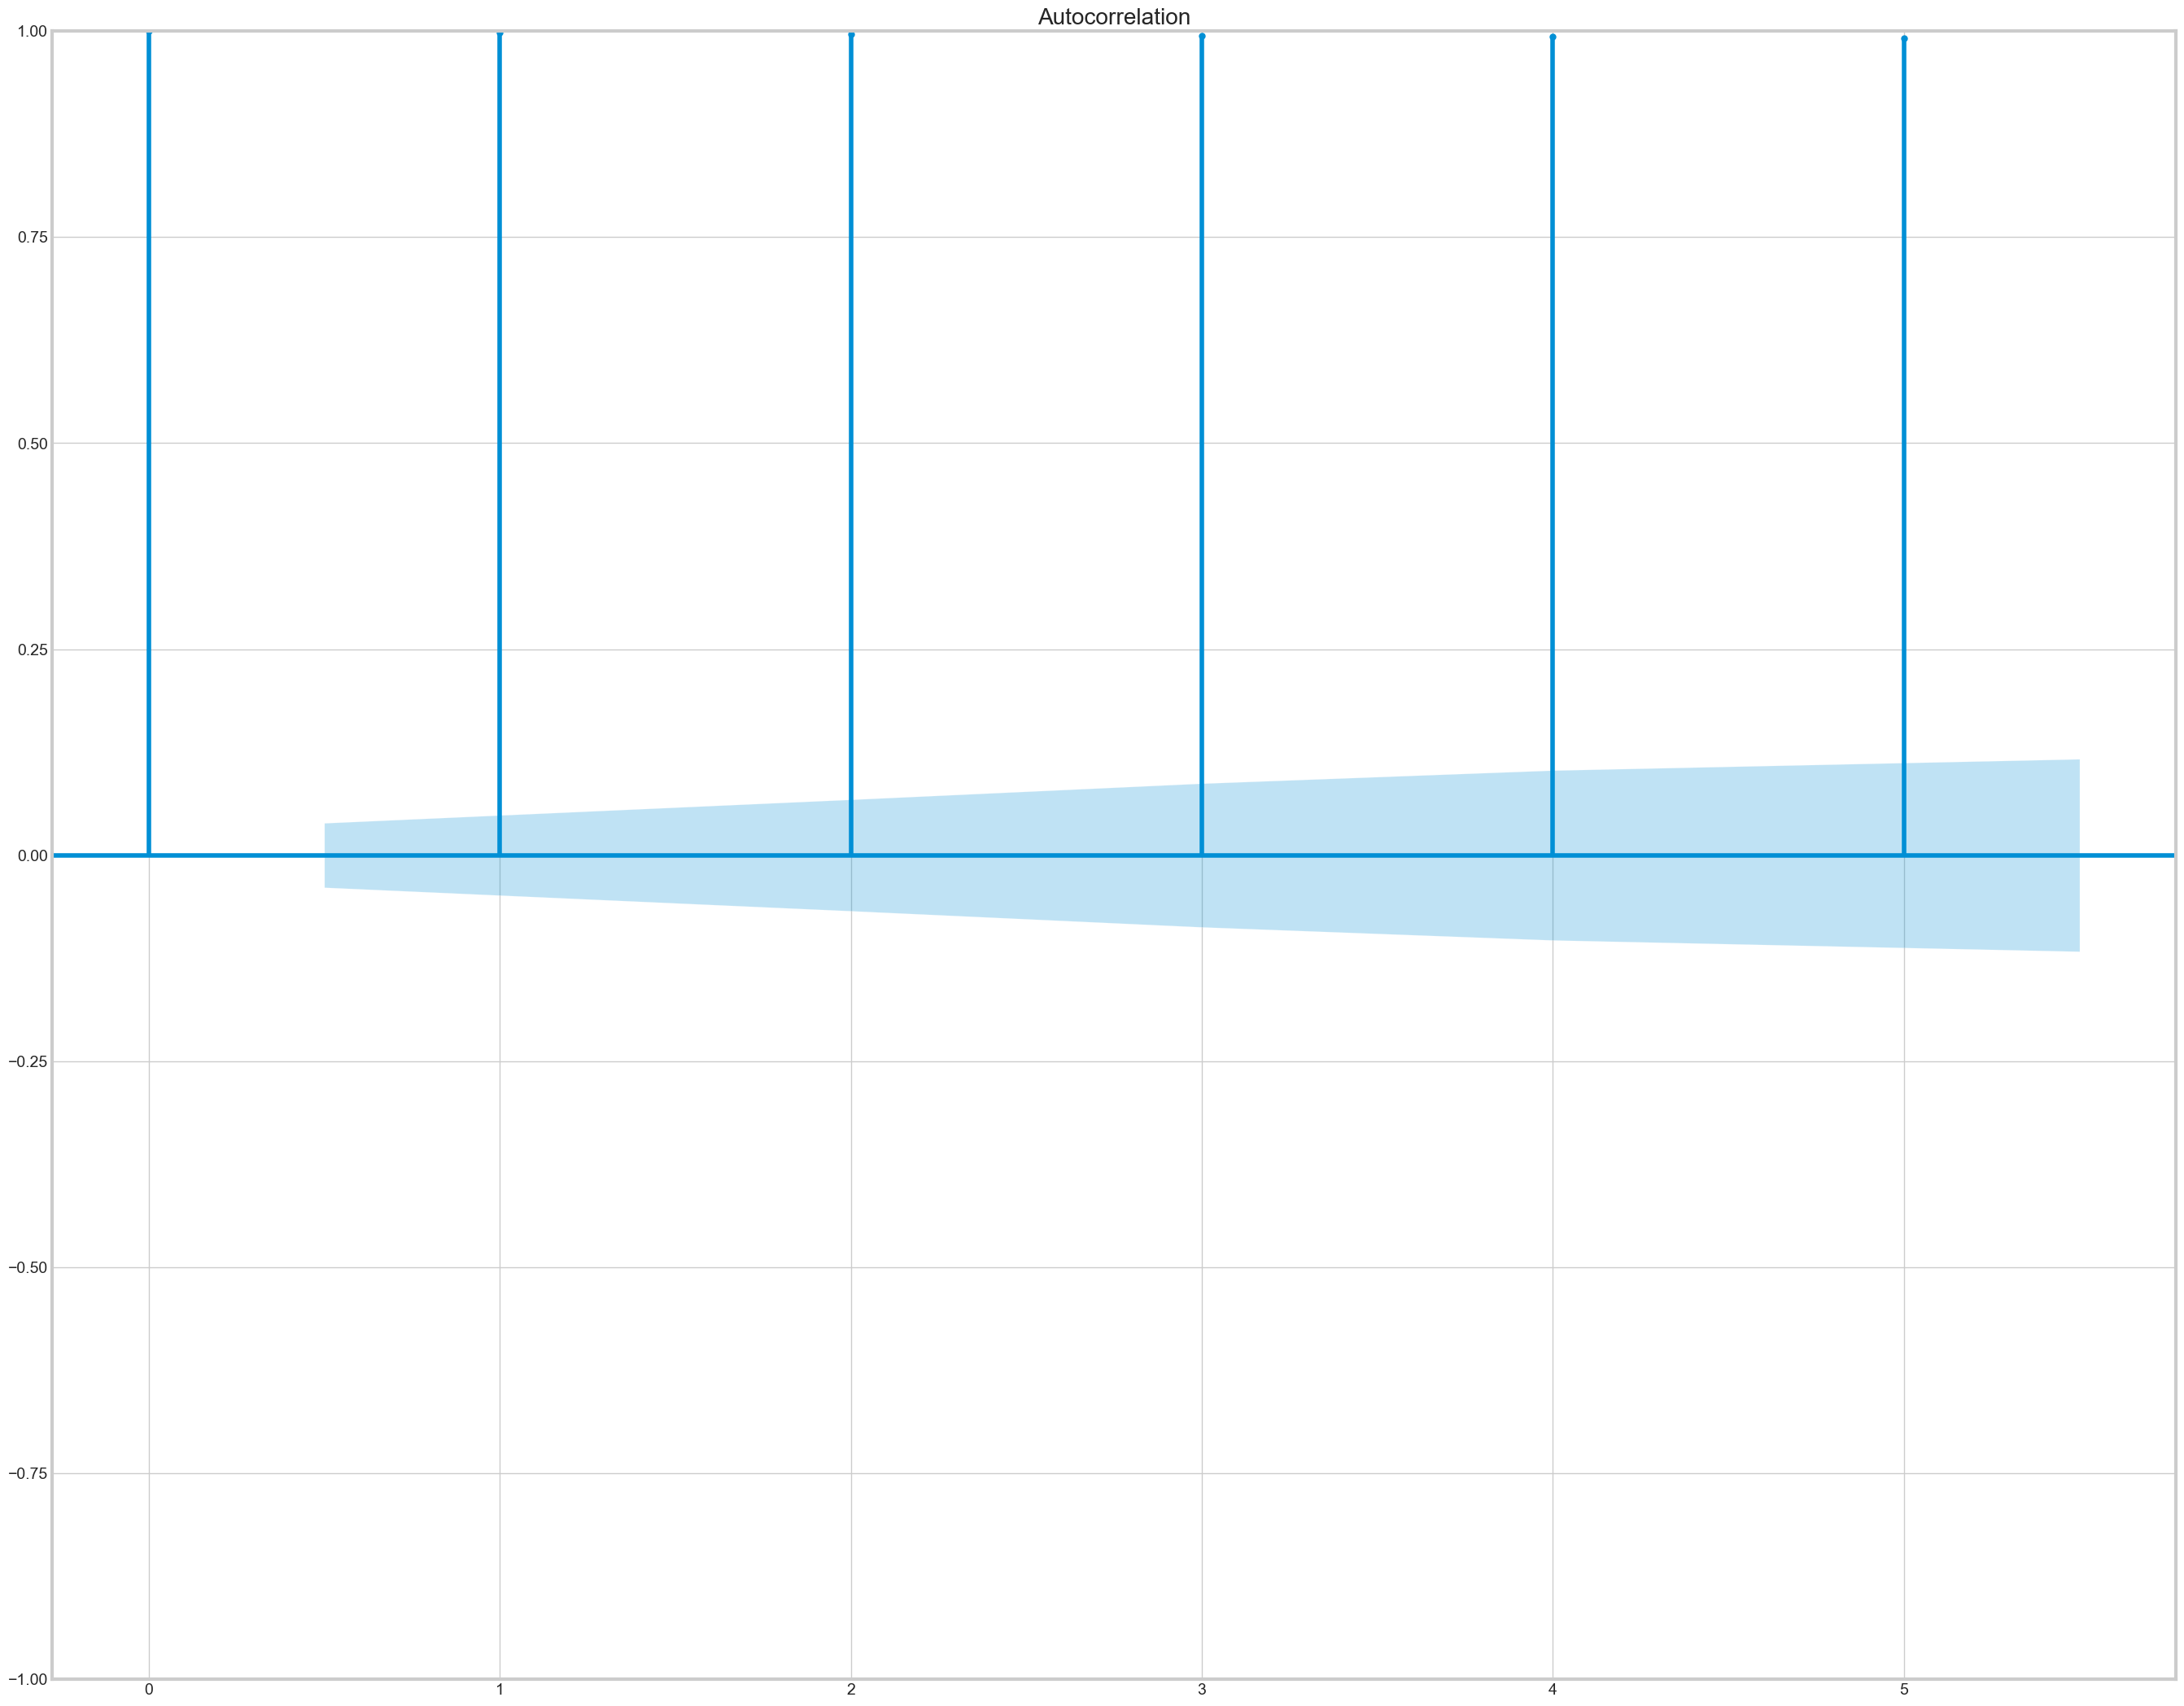

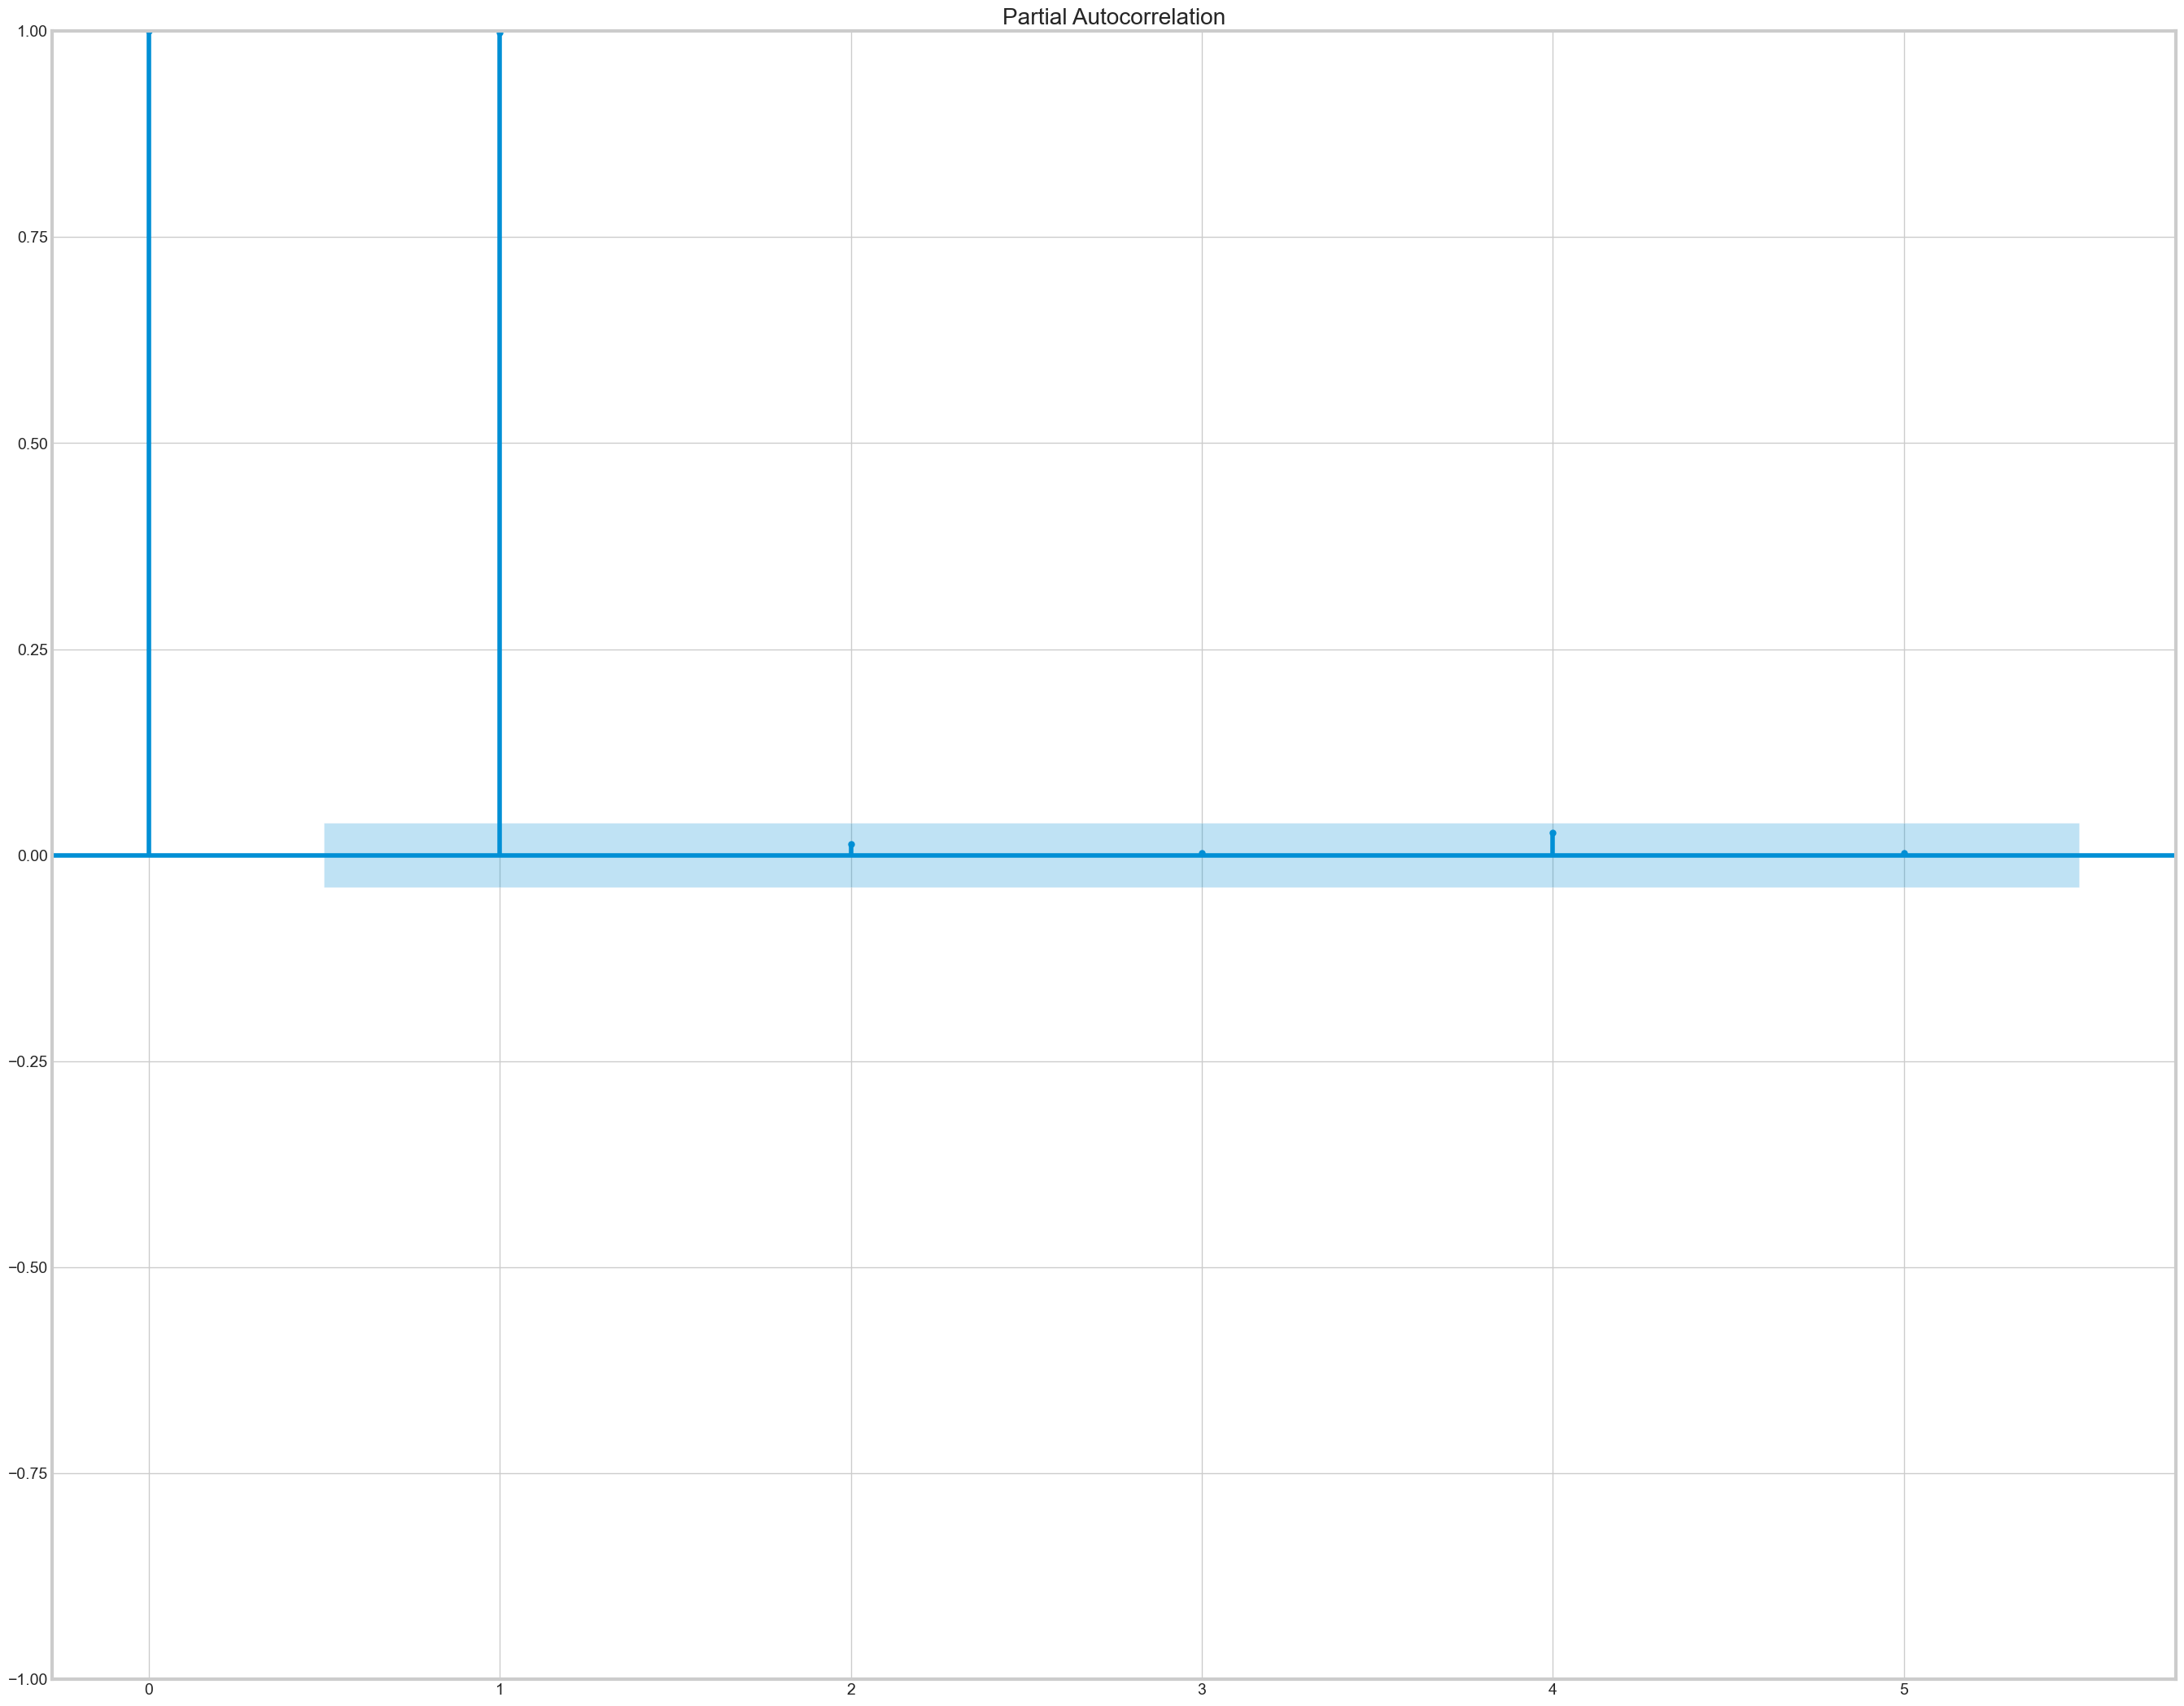

In [73]:
plot_acf(df_goog, lags=5)
plot_pacf(df_goog, lags=5)
plt.savefig('ARIMA_correlation.png', bbox_inches='tight')

We can see from PACF that lag 1 and 2 are significant. From ACF all 5 lags are significant.

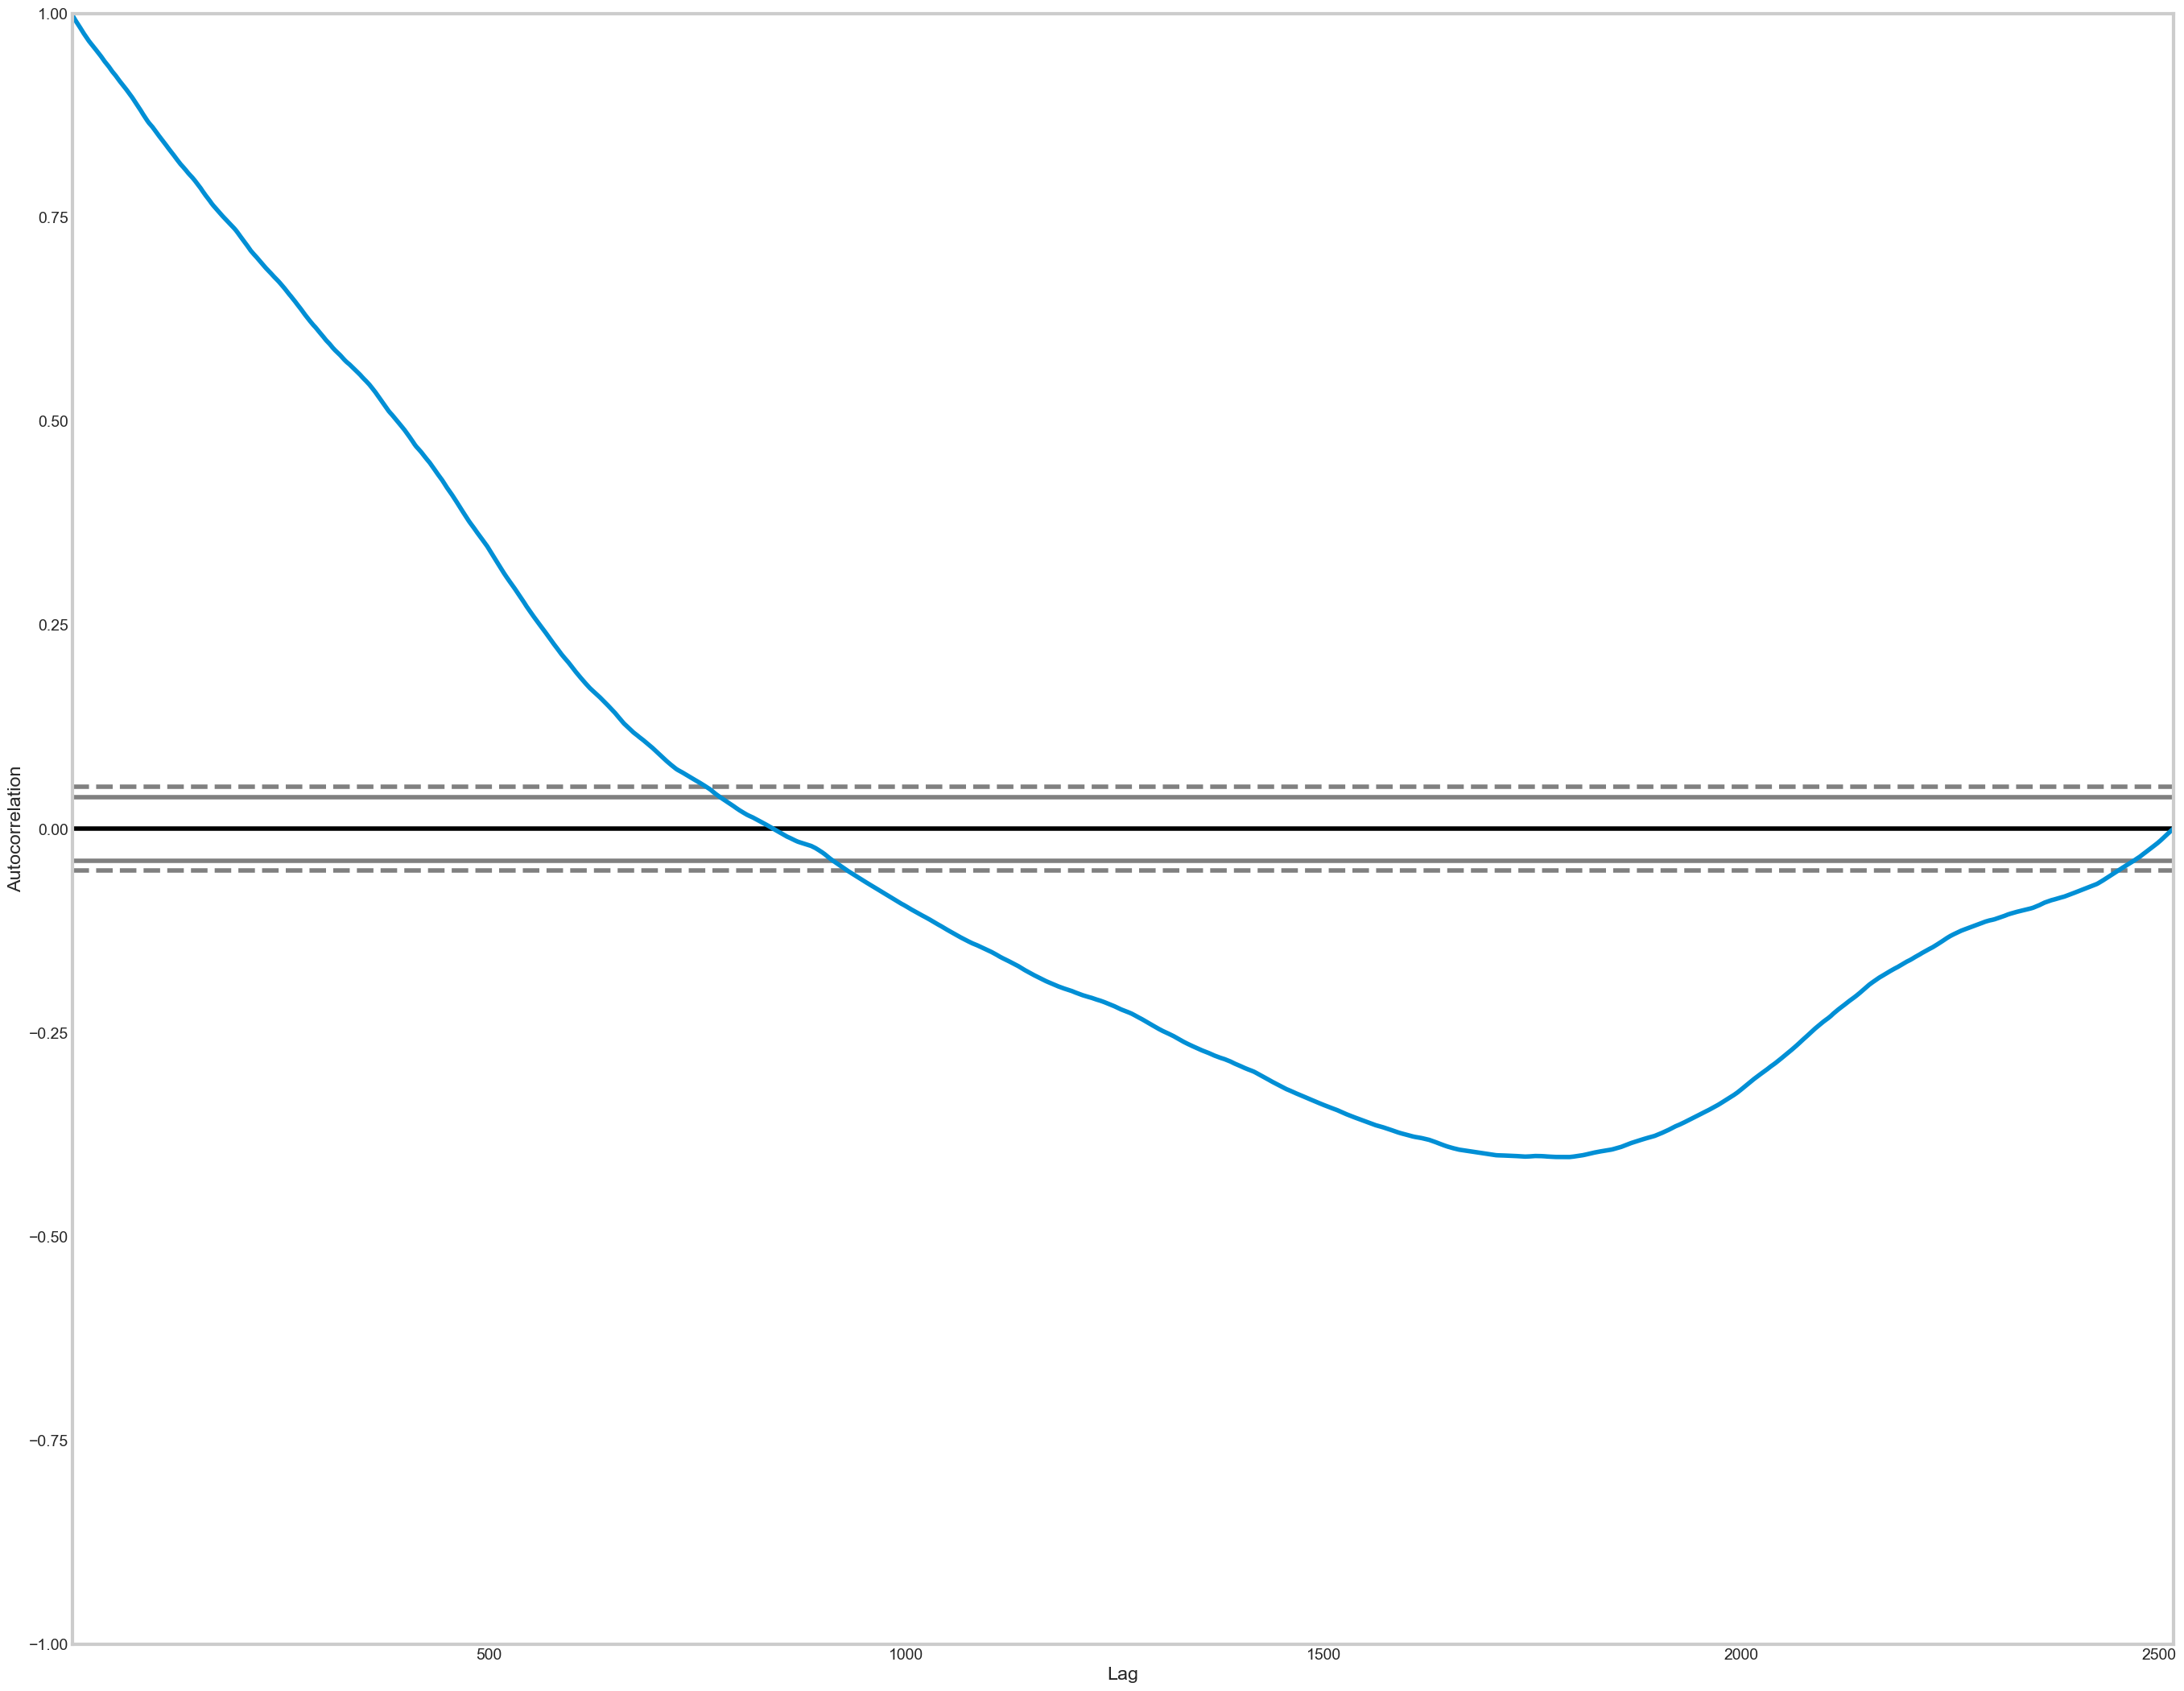

<Figure size 800x560 with 0 Axes>

In [74]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_goog)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

We will use the Augmented Dickey Fuller (ADF) test to detect stationarity in our dataset. Our hypothesis is as follows:

Ho: the time series is non-stationary

H1: the time series is stationary

If the p-value is less than the significance level of 0.05 we reject our null hypothesis.

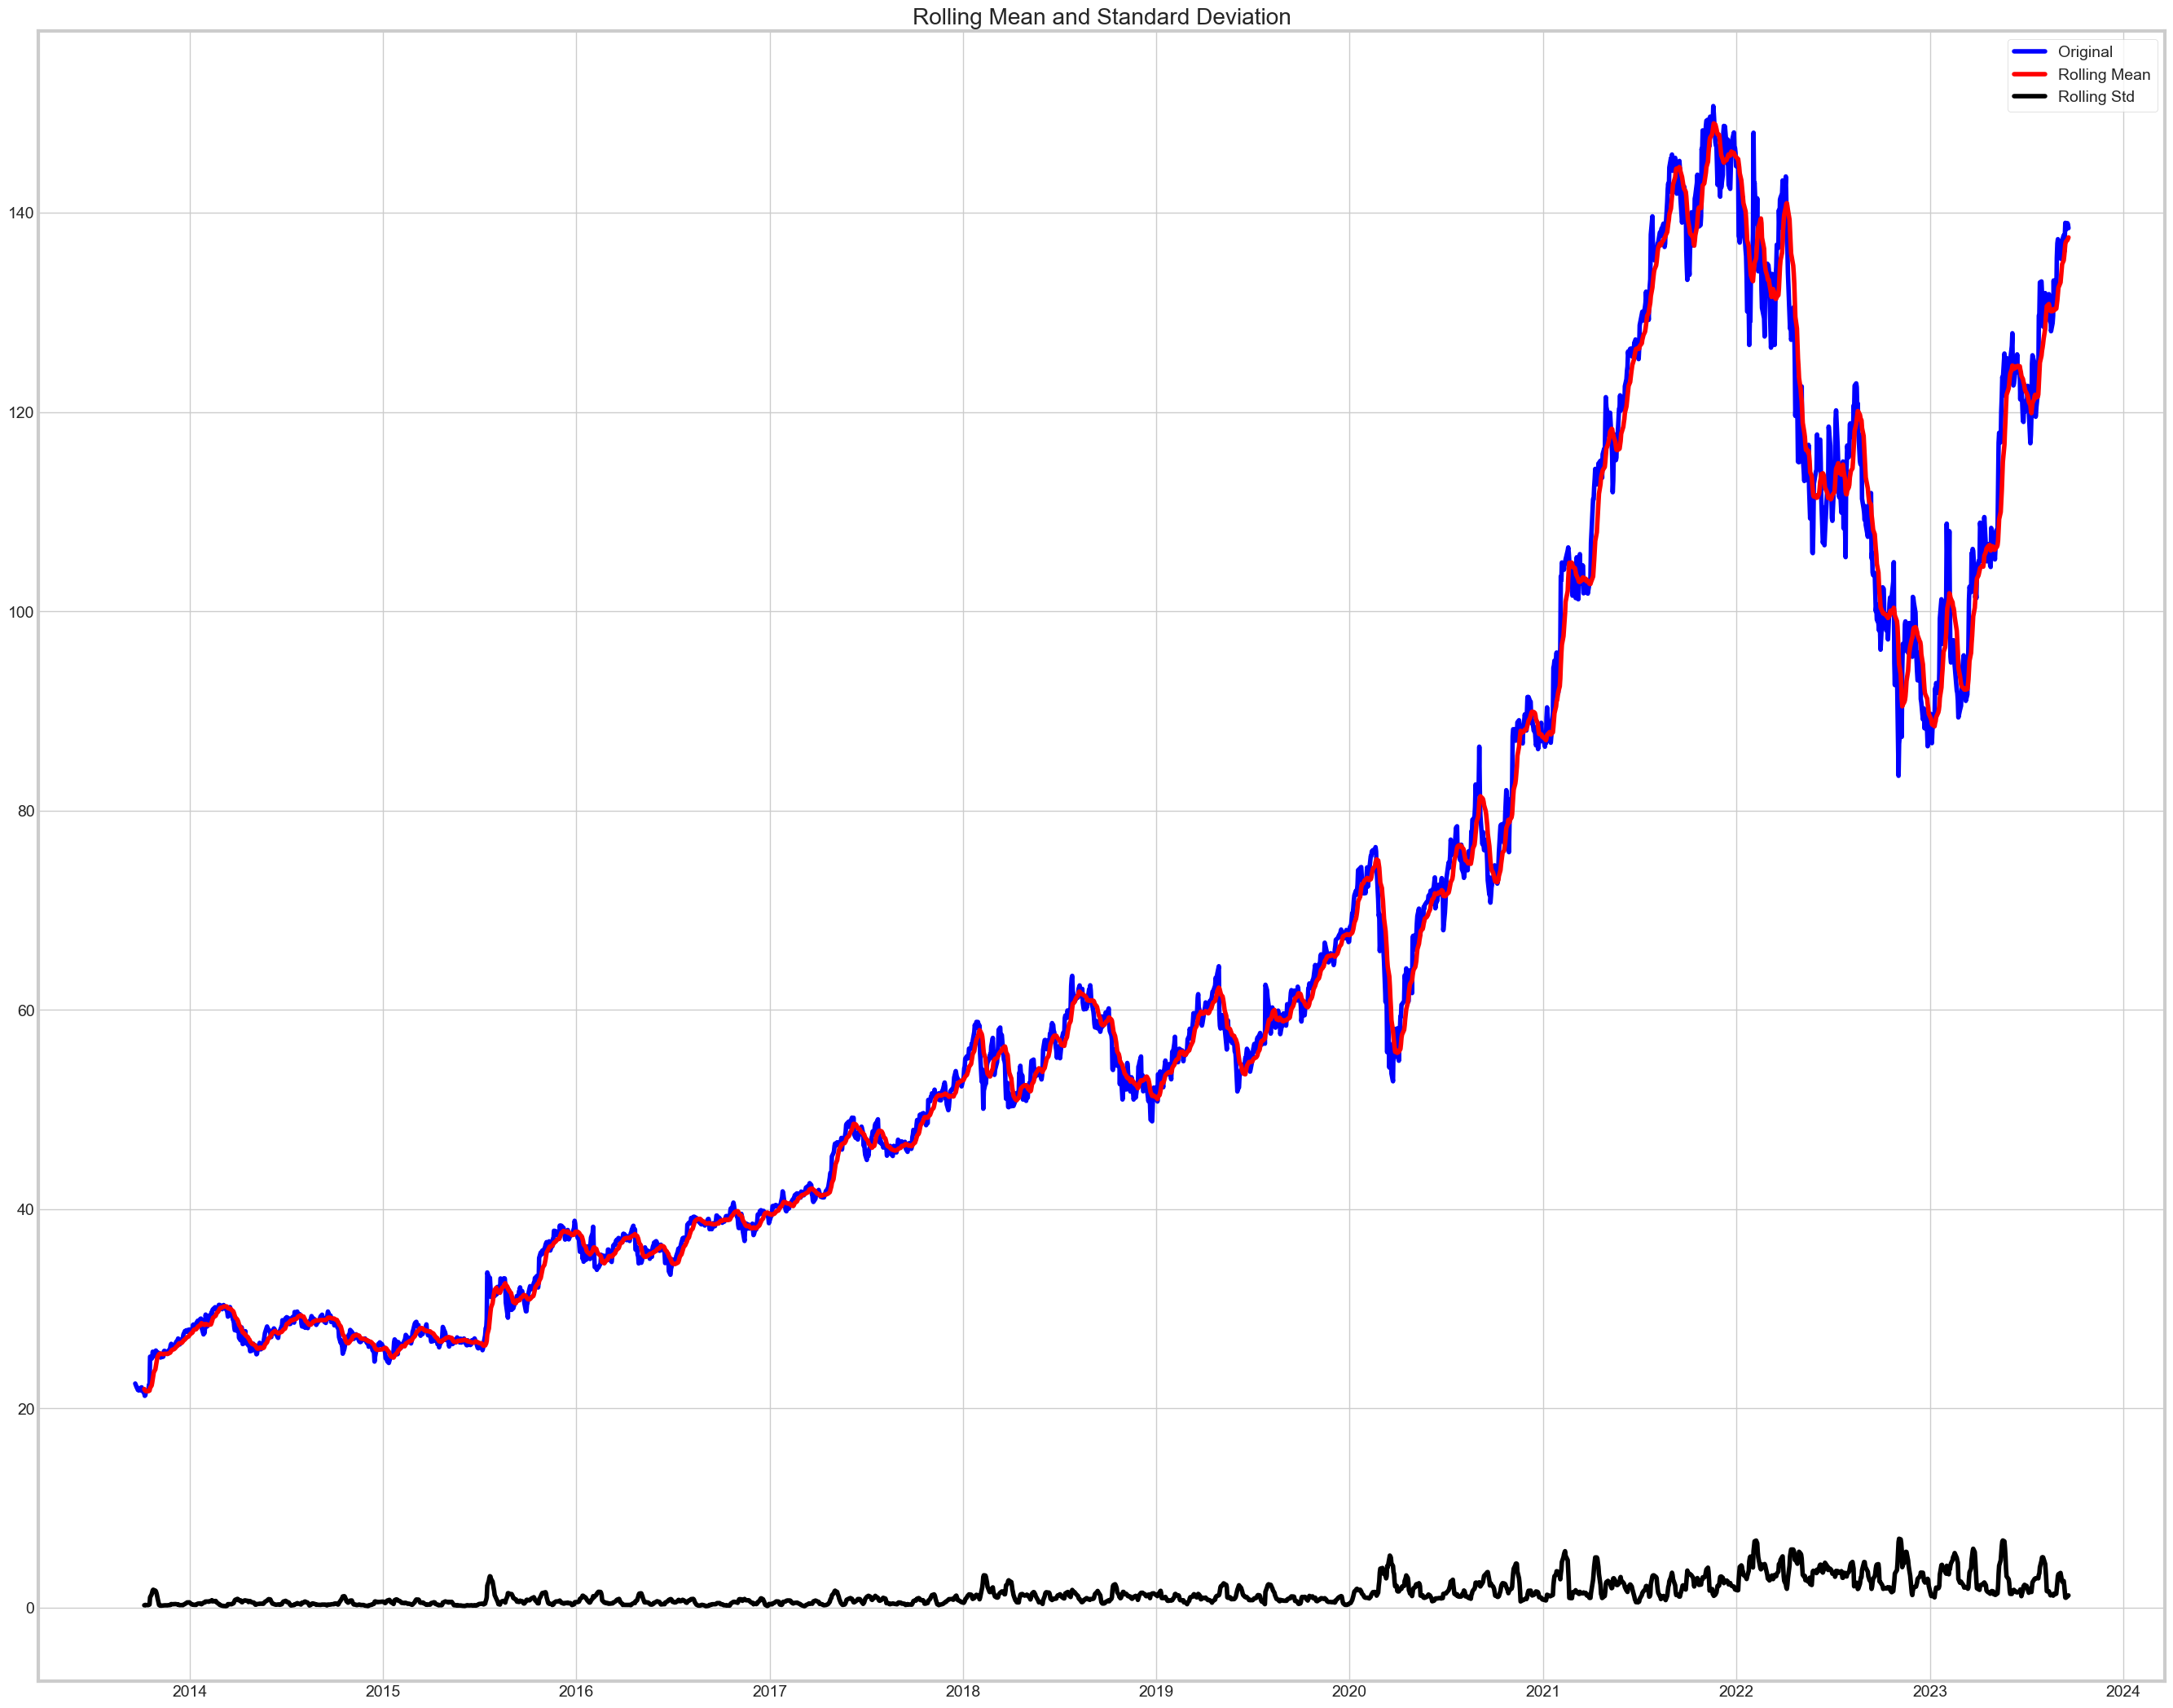

Results of dickey fuller test
Test Statistics                0.183579   
p-value                        0.971325   
No. of lags used               23.000000  
Number of observations used    2493.000000
critical value (1%)           -3.432976   
critical value (5%)           -2.862700   
critical value (10%)          -2.567388   
dtype: float64


In [75]:
#Test for staionarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_goog)

The p-value of 0.97 is above 0.05 which means we accept our null hypothesis that our data is non-stationary. To perform time series analysis, we will decompose time series data into trend and seasonality.

<Figure size 3000x2500 with 0 Axes>

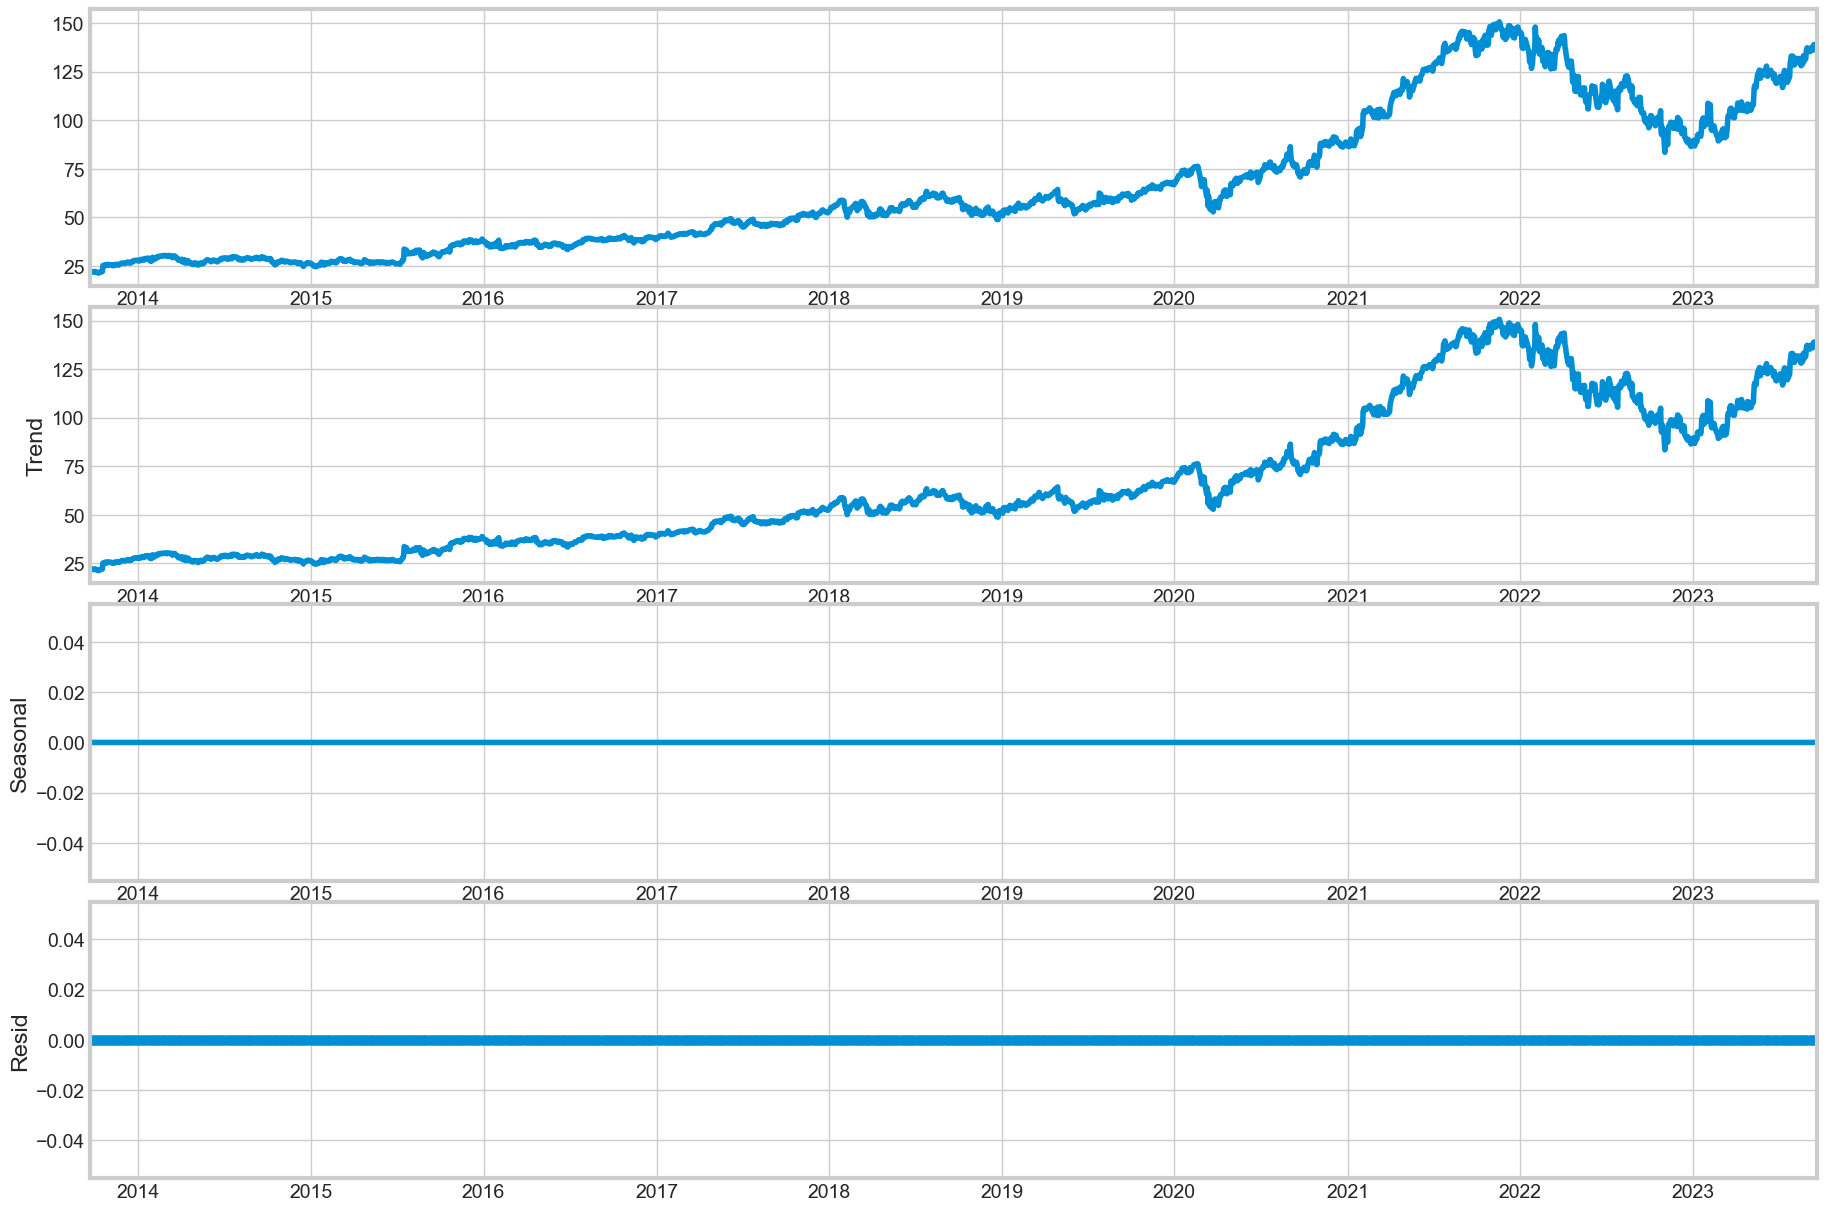

In [76]:
# We will decompose the series to separate the trend and seasonality from the time series. 
result = seasonal_decompose(df_goog, model='additive', period=1)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(18, 12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


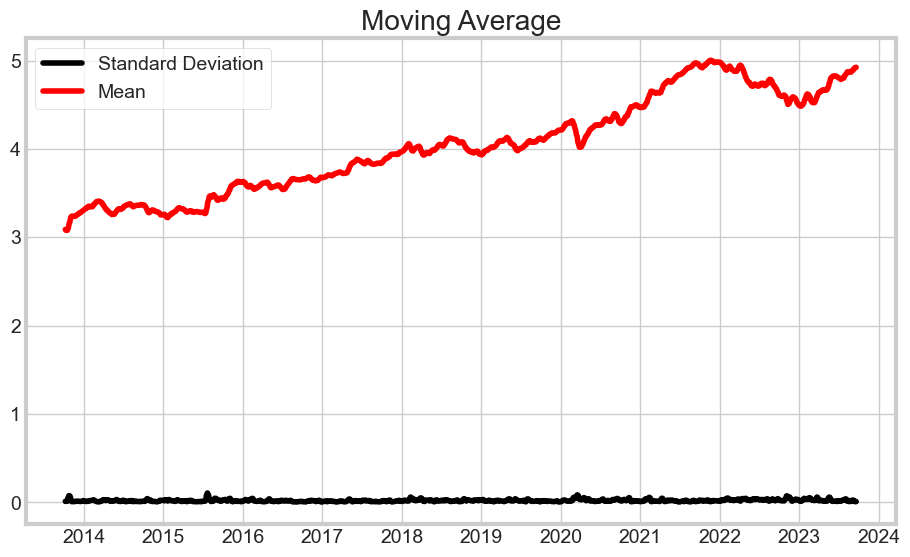

In [77]:
#We will eliminate the non-stationary trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_goog)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [78]:
X, y = df_log[0:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
training_data = X.values
testing_data = y.values

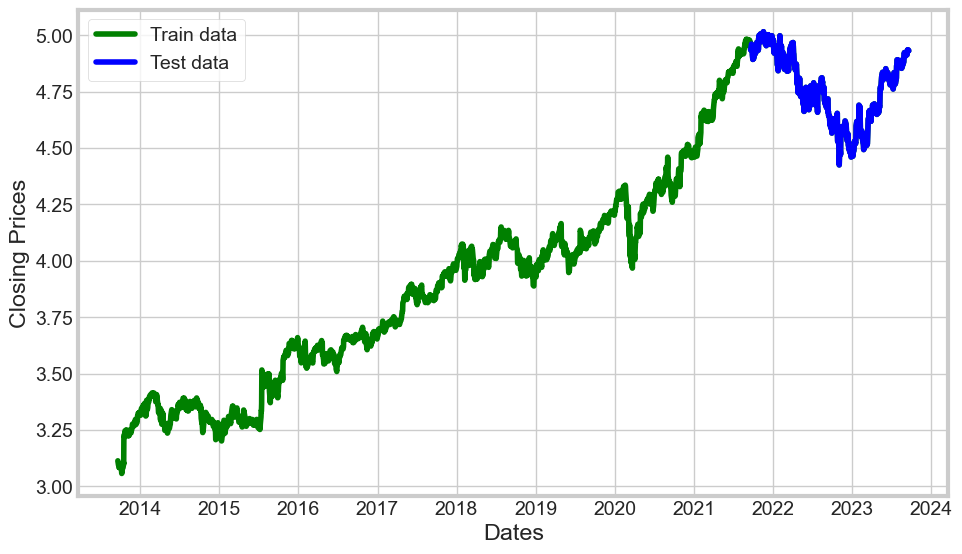

In [79]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(y, 'blue', label='Test data')
plt.legend()

We will now build our ARIMA model and identify the right parameters.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10838.599, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10847.534, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10847.386, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10834.323, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10845.577, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10845.580, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10843.170, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10842.265, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.250 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2013
Model:               SARIMAX(1, 1, 0)   Log Likelihood                5426.767
Date:                Wed, 20 Sep 2023   AIC                         -10847.534
Time:               

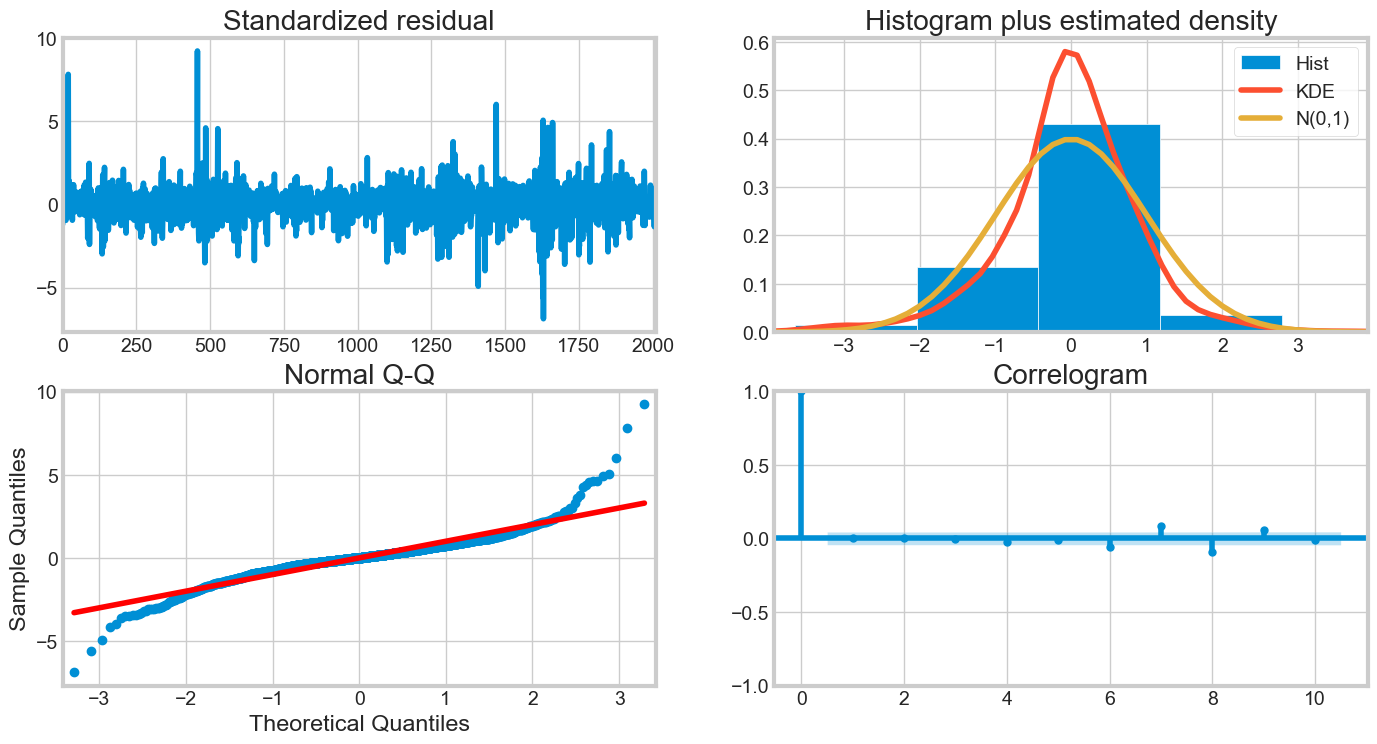

In [80]:
model_autoARIMA = auto_arima(X, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,          
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

The plot diagnostics above infer the following:

Standard redisual: the residual errors fluctuate around zero and have a uniform variance.

Histogram plus estimated density: the histogram plot infers a normal distribution with mean of zero.

Normal Q-Q: Towards the centre, the red line is aligned with the dots however the edges deviate from the line which could imply skewness exists in the distribution.

Correlogram: The residual errors are not autcorrelated. Autocorrelation would imply the residual errors have an unexplainable pattern.

The optimum model for forecasting indicates ARIMA(1,1,0)(0,0,0)[0] is the best model.

In [81]:
history = [x for x in training_data]
predictions = list()
for t in range(len(testing_data)):
    model = ARIMA(history, order=(1,1,0))  
    fitted = model.fit()  
    output = fitted.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = testing_data[t]
    history.append(obs)

In [82]:
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))

MSE: 0.000468309583210593


In [83]:
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))

MAE: 0.01623576296023498


In [84]:
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

RMSE: 0.02164046171435797


C:\Users\329707\AppData\Local\Temp\ipykernel_13308\3017601162.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "green" (-> color=(0.0, 0.5019607843137255, 0.0, 1.0)). The keyword argument will take precedence.
  plt.plot(df_log,'green', color='blue', label='Training Data')


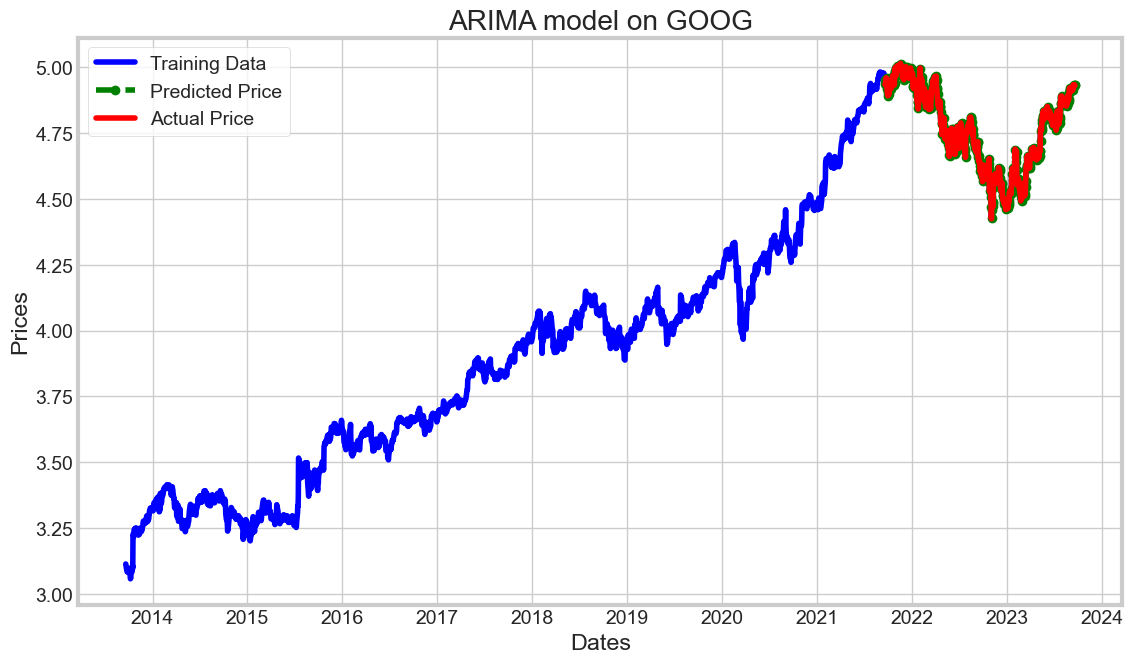

In [85]:
plt.figure(figsize=(12,7))
plt.plot(df_log,'green', color='blue', label='Training Data')
plt.plot(y.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(y.index, y, color='red', label='Actual Price')
plt.title('ARIMA model on GOOG')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

plt.savefig('ARIMA_prediction.png', bbox_inches='tight')

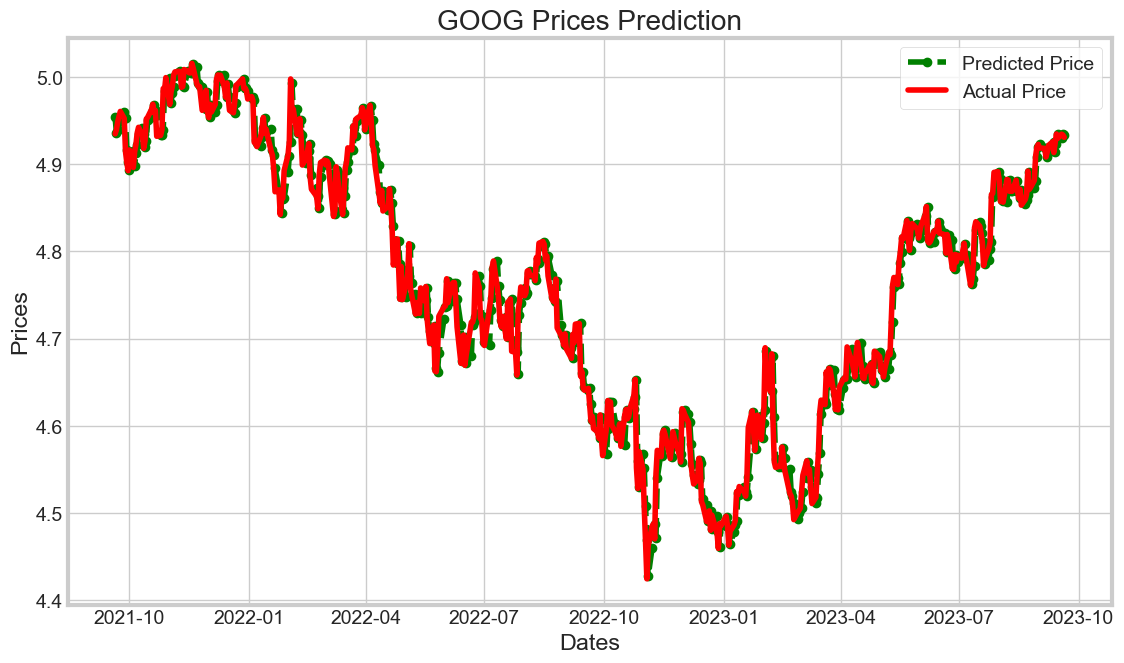

In [86]:
plt.figure(figsize=(12,7))
plt.plot(y.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(y.index, y, color='red', label='Actual Price')
plt.title('GOOG Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

The model has peformed well and the prediction shows an accurate forecast. The error metrics indicate high accuracy of the model due to lower values obtained for RMSE, MSE and MAE.

Overall, we can conclude that the ARIMA model performs better than the LSTM model. This is because the data has been normalised, which means the ARIMA model better explained the time-series based on historical linear data with simple temporal dependencies. The LSTM model was a better fit for time-series data with long-term dependencies. Although, we have found these
models are not entirely accurate with predicting stock prices as accuracy metrics show elements of error, therefore, the organisation should factor in human judgement when making risk decisions. 